# Import packages

In [2]:
from bs4 import BeautifulSoup
from IPython.core.display import clear_output
from nltk.corpus import stopwords
from pprint import pprint
from random import randint
from requests import get
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from time import sleep
from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm import tqdm_notebook
from urllib.request import urlopen
from warnings import warn
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

To-do list:
    
    -Translate story and redo content based recommender
    -Add cluster analysis for cluster based on tf-idf
    -Add tf-idf scores to ratings estimation
    -Add rating from daserste.de
    -Add ratingcount from daserste.de
    -Add sentiment from daserste.de

# Introduction

Background:

Welcome to the Tatort Data Science project. This project is about the German television series "Tatort". Wikipedia says about Tatort: 

Tatort (Crime scene) is a German language police procedural television series that has been running continuously since 1970 with some 30 feature-length episodes per year, which makes it the longest-running German TV drama. Developed by the German public-service broadcasting organisation ARD for their channel Das Erste, it is unique in its approach, in that it is jointly produced by all of the organisation's regional members as well as its partnering Austrian and Swiss national public-service broadcasters, whereby every regional station contributes a number of episodes to a common pool.

Therefore, the series is a collection of different police stories where different police teams each solve crimes in their respective city. Uniqueness in architecture, customs and dialects of the cities is therefore a distinctive part of the series and often the city, not the police force is the real main character of an episode. The concept of local stations only producing a couple of shows per year has also enabled the shows to be longer (90 minutes) and more fleshed out psychologically than other weekly TV dramas.

The first episode was broadcast on 29 November 1970. Episodes are broadcast on ARD's main channel Das Erste on Sunday evening at the prime viewing time of 8.15 pm (just after the 8 o'clock Tagesschau news) around three times a month. Reruns are often shown by various regional ARD stations and on foreign broadcasters. Next to the member stations of the ARD, the National Austrian broadcasting corporation Österreichischer Rundfunk joined the production pool in 1971 and airs the program on its ORF 2 channel. Switzerland's Schweizer Fernsehen joined the pool from 1990 to 2001 and again in 2011 and distributes its episodes through its channel SRF 1.

The series Polizeiruf 110, which was produced by East Germany’s state TV broadcaster as a counterpart to the West German Tatort and has a similar regional production approach, is still produced by ARD's regional broadcasters Mitteldeutscher Rundfunk (MDR), Rundfunk Berlin-Brandenburg (RBB), Norddeutscher Rundfunk (NDR) and Bayerischer Rundfunk (BR). Polizeiruf 110 shares the Sunday night prime time slot on Das Erste with Tatort. 

For this project the following steps are being done:

 -Download data and transform it<br>
 -Analyze the data (Exporatory Data Analysis - EDA)<br>
 -Build a recommendation system<br>
 -Build a model to forecast votes<br>
 
We will start with the download and analysis of the data. Enjoy :)

# Scrape Data

Here we are getting the linklist and download information from each page.

In [ ]:
#Set the variables for the scraper
headers = {"Accept-Language": "en-US, en;q=0.5"}

#specify the url
urlpage = 'https://www.tatort-blog.de/folgen/' 
print(urlpage)

#run Chrome webdriver from executable path of your choice
driver = webdriver.Chrome("C:/Users/Armin/Downloads/chromedriver.exe")
driver.maximize_window()

#get web page
driver.get(urlpage)

#scroll
element = driver.find_element_by_xpath('//*[@id="outer-content-wrapper"]/article/div')
actions = ActionChains(driver)
actions.move_to_element(element).perform()

#sleep for 5s
sleep(5)

#Amount of episodes and pages
Amount_of_episodes = [t.text for t in driver.find_elements_by_xpath('/html/body/div[2]/main/div/article/div/div[3]/div/div/div/div/table/tbody/tr[1]/td[1]')]
Amount_of_episodes = [int(i) for i in Amount_of_episodes]
Amount_of_pages = round(Amount_of_episodes[0] / 10)+1

#define list
Numbers_temp = []
Dates_temp =[]
Titles_temp = []
Detectives_temp = []
Places_temp = []
Links_temp = []
Text_set_Viewers_and_ratings_temp = []
Amount_Text_set_Viewers_and_ratings_temp = []
Ratings_temp = []
Ratingcounts_temp = []
TV_stations_temp = []
Actors_temp = []
Amount_actors_temp = []

#loop run
for i in tqdm(range(Amount_of_pages)):

    Number = [t.text for t in driver.find_elements_by_xpath('/html/body/div[2]/main/div/article/div/div[3]/div/div/div/div/table/tbody/tr/td[1]')]
    Numbers_temp.append(Number[:10])
    
    Date = [t.text for t in driver.find_elements_by_xpath('/html/body/div[2]/main/div/article/div/div[3]/div/div/div/div/table/tbody/tr/td[5]')]
    Dates_temp.append(Date)
        
    Title = [t.text for t in driver.find_elements_by_xpath('/html/body/div[2]/main/div/article/div/div[3]/div/div/div/div/table/tbody/tr/td[2]')]
    Titles_temp.append(Title)
    
    Detective = [t.text for t in driver.find_elements_by_xpath('/html/body/div[2]/main/div/article/div/div[3]/div/div/div/div/table/tbody/tr/td[3]')]
    Detectives_temp.append(Detective)
    
    Place = [t.text for t in driver.find_elements_by_xpath('/html/body/div[2]/main/div/article/div/div[3]/div/div/div/div/table/tbody/tr/td[4]')]
    Places_temp.append(Place)

    Link = [t.find_element_by_tag_name('a').get_attribute("href") for t in driver.find_elements_by_xpath('/html/body/div[2]/main/div/article/div/div[3]/div/div/div/div/table/tbody/tr/td[2]')]
    Links_temp.append(Link)
    
    from requests import get
    import re
    import requests

    #loop through linklist
    for url in Link:
        html = requests.get(url)
        soup = BeautifulSoup(html.content)

        Text_set_Viewers_and_rating = soup.find_all('p', class_='bodytext')
        Text_set_Viewers_and_ratings_temp.append(Text_set_Viewers_and_rating)
        
        Amount_Text_set_Viewers_and_rating = len(soup.find_all('p', class_='bodytext'))
        Amount_Text_set_Viewers_and_ratings_temp.append(Amount_Text_set_Viewers_and_rating)

        Rating = soup.find("span", itemprop="ratingValue").get_text(strip=True)
        Ratings_temp.append(Rating)

        Ratingcount = soup.find("span", itemprop="ratingCount").get_text(strip=True)
        Ratingcounts_temp.append(Ratingcount)
        
        TV_station = soup.find('div', class_='episodendetails_box').get_text(strip=True)
        TV_stations_temp.append(TV_station)
        
        Actor  = soup.find_all('div', class_='schauspieler_name')
        Actors_temp.append(Actor)
        
        Amount_actor  = len(soup.find_all('div', class_='schauspieler_name'))
        Amount_actors_temp.append(Amount_actor)
                             
    try:
        #Checks if there are more pages with links
        next_link = driver.find_element_by_xpath('//*[@id="episoden-ende"]/td/a[2]/div/img')
        next_link.click()
        sleep(randint(3,8))
        
    except AttributeError:
        pass
    clear_output(wait = True)
print("Finished!")

In [18]:
Numbers = pd.concat([pd.DataFrame(d) for d in Numbers_temp]).reset_index()
Dates = pd.concat([pd.DataFrame(d) for d in Dates_temp]).reset_index()
Detectives = pd.concat([pd.DataFrame(d) for d in Detectives_temp]).reset_index()
Titles = pd.concat([pd.DataFrame(d) for d in Titles_temp]).reset_index()
Places = pd.concat([pd.DataFrame(d) for d in Places_temp]).reset_index()
Links = pd.concat([pd.DataFrame(d) for d in Links_temp]).reset_index()
Text_set_Viewers_and_ratings = pd.DataFrame(Text_set_Viewers_and_ratings_temp)
Amount_Text_set_Viewers_and_ratings = max(Amount_Text_set_Viewers_and_ratings_temp)
Ratings = pd.DataFrame(Ratings_temp)
Ratingcounts = pd.DataFrame(Ratingcounts_temp)
TV_stations = pd.DataFrame(TV_stations_temp)
Actors = pd.DataFrame(Actors_temp)
Amount_actors = pd.DataFrame(Amount_actors_temp)

In [19]:
Tatort_list = pd.concat([Numbers, Dates, Detectives, Titles, Places, Links, Ratings, Ratingcounts, TV_stations, Actors, Amount_actors, Text_set_Viewers_and_ratings], axis=1)
Tatort_list.drop(columns =["index"], inplace = True)
Tatort_list.columns = ["Numbers","Dates", "Detectives","Title","Place","Links","Ratings x/5","Ratingcounts","TV_stations","Actors", "Actors_2", "Actors_3", "Actors_4", "Actors_5", "Actors_6", "Actors_7", "Actors_8", "Actors_9", "Actors_10", "Actors_11", "Actors_12", "Actors_13", "Actors_14", "Actors_15", "Actors_16", "Actors_17", "Actors_18", "Actors_19", "Actors_19" ,"Amount_actors", "Text_set_Viewers_and_ratings","Text_set_Viewers_and_ratings_2","Text_set_Viewers_and_ratings_3","Text_set_Viewers_and_ratings_4","Text_set_Viewers_and_ratings_5","Text_set_Viewers_and_ratings_6","Text_set_Viewers_and_ratings_7","Text_set_Viewers_and_ratings_8","Text_set_Viewers_and_ratings_9","Text_set_Viewers_and_ratings_10","Text_set_Viewers_and_ratings_11","Text_set_Viewers_and_ratings_12"]
Tatort_list.head()

,Numbers,Dates,Detectives,Title,Place,Links,Ratings x/5,Ratingcounts,TV_stations,Actors,...,Text_set_Viewers_and_ratings_3,Text_set_Viewers_and_ratings_4,Text_set_Viewers_and_ratings_5,Text_set_Viewers_and_ratings_6,Text_set_Viewers_and_ratings_7,Text_set_Viewers_and_ratings_8,Text_set_Viewers_and_ratings_9,Text_set_Viewers_and_ratings_10,Text_set_Viewers_and_ratings_11,Text_set_Viewers_and_ratings_12
0,1102,08.09.2019,Odenthal/Stern,Maleficius,Ludwigshafen,https://www.tatort-blog.de/folgen/tatort-ludwi...,2.8,19,Tatort InfosEpisode1102StadtLudwigshafenErmitt...,"[Lena Odenthal , [], , [Ulrike Folkerts]]",...,[Die Möglichkeiten der Gehirnstimulation und d...,"[Regie: Thomas Bohn, [], Drehbuch: Thomas Bohn...",None,None,None,None,None,None,None,None
1,1101,01.09.2019,Brix/Janneke,Falscher Hase,Frankfurt,https://www.tatort-blog.de/folgen/tatort-frank...,3.6,50,Tatort InfosEpisode1101StadtFrankfurtErmittler...,"[Paul Brix , [], , [Wolfram Koch]]",...,[Als die Möchtegerngangster dann auch noch mit...,"[Regie: Emily Atef, [], Drehbuch: Emily Atef, ...",None,None,None,None,None,None,None,None
2,1100,18.08.2019,Gorniak/Winkler,Nemesis,Dresden,https://www.tatort-blog.de/folgen/tatort-dresd...,3.5,73,Tatort InfosEpisode1100StadtDresdenErmittlerGo...,"[Kommissariatsleiter Peter Michael Schnabel , ...",...,"[Regie: Stephan Wagner, [], Drehbuch: Mark Mon...",None,None,None,None,None,None,None,None,None
3,1099,16.06.2019,Flückiger/Ritschard,Ausgezählt,Luzern,https://www.tatort-blog.de/folgen/tatort-luzer...,3.3,25,Tatort InfosEpisode1099StadtLuzernErmittlerFlü...,"[Liz Ritschard , [], , [Delia Mayer]]",...,[Die Zeit drängt und der geständige Mörder Hei...,"[Regie: Katalin Gödrös, [], Drehbuch: Urs Bühl...","[Quote bei der Erstausstrahlung: 23,4% (7,00 M...",None,None,None,None,None,None,None
4,1098,10.06.2019,Ballauf/Schenk,Kaputt,Köln,https://www.tatort-blog.de/folgen/tatort-koeln...,3.3,40,Tatort InfosEpisode1098StadtKölnErmittlerBalla...,"[Max Ballauf , [], , [Klaus J. Behrendt]]",...,"[Regie: Christine Hartmann, [], Drehbuch: Rain...","[Quote bei der Erstausstrahlung: 29,2% (9,29 M...",None,None,None,None,None,None,None,None


In [20]:
#The end result looks good
Tatort_list.dtypes

Numbers                            object
Dates                              object
Detectives                         object
Title                              object
Place                              object
Links                              object
Ratings x/5                        object
Ratingcounts                       object
TV_stations                        object
Actors                             object
Actors_2                           object
Actors_3                           object
Actors_4                           object
Actors_5                           object
Actors_6                           object
Actors_7                           object
Actors_8                           object
Actors_9                           object
Actors_10                          object
Actors_11                          object
Actors_12                          object
Actors_13                          object
Actors_14                          object
Actors_15                         

In [21]:
Tatort_list.to_csv('Tatort_list_base.CSV',sep=',')

After we have done this step, we can start to prepare the data. The more we prepare, the less work we have to do in the end.

## Prepare data

Here we will start to prepare our data for the analysis. Since it is scraped data, we have to do these steps.

In [3]:
Tatort_list = pd.read_csv('Tatort_list_base.CSV', engine='python', encoding='utf-8', index_col=0)

#Some cleaning and manipulation
Tatort_list['Dates'] = Tatort_list['Dates'].astype('datetime64[ns]')
Tatort_list['Ratings x/5'] = Tatort_list['Ratings x/5'].astype(float)
Tatort_list['Ratingcounts'] = Tatort_list['Ratingcounts'].astype(float)

#Lets combine some columns
Tatort_list['combined'] = Tatort_list.loc[:, Tatort_list.columns.str.startswith('Text')].apply(lambda x: x.str.cat(sep=' '), axis=1)
Tatort_list.drop(columns = Tatort_list.loc[:, Tatort_list.columns.str.startswith('Text')], inplace = True) 

#Splitting and cleaning of the  columns
Tatort_list['Numbers'] = Tatort_list['Numbers'].str.replace('a', '') 
Tatort_list['Numbers'] = Tatort_list['Numbers'].str.replace('b', '') 
Tatort_list['Numbers'] = Tatort_list['Numbers'].astype('int64')
Tatort_list.rename( columns={'Numbers':'Number_Episode'}, inplace=True )
Tatort_list['combined'] = Tatort_list['combined'].str.replace('<[^<]+?>', '') 
Tatort_list['combined'] = Tatort_list['combined'].str.replace('\r', '')
Tatort_list['Story'] = Tatort_list['combined'].str.split("Regie: ", n = 1, expand = True)[0]
Tatort_list['Director'] = Tatort_list['combined'].str.split("Regie: ", n = 1, expand = True)[1].str.split("Drehbuch: ", n = 1, expand = True)[0]
Tatort_list['Script'] = Tatort_list['combined'].str.split("Drehbuch: ", n = 1, expand = True)[1].str.split("Kamera: ", n = 1, expand = True)[0]
Tatort_list['Camera'] = Tatort_list['combined'].str.split("Kamera: ", n = 1, expand = True)[1].str.split("Quote bei der Erstausstrahlung: ", n = 1, expand = True)[0]
Tatort_list['Story_words_amount'] = Tatort_list['Story'].apply(lambda x: len(str(x).split(" ")))
Tatort_list['Story_len'] = Tatort_list['Story'].apply(len)

#Lets add some counts here
Tatort_list['Amount_Director'] = Tatort_list['Director'].str.count(",") + 1
Tatort_list['Amount_Script'] = Tatort_list['Script'].str.count(",") + 1
Tatort_list['Amount_Camera'] = Tatort_list['Camera'].str.count(",") + 1

#Let us now turn to the story, script, ratings, viewers and crew
Tatort_list['Temp'] = Tatort_list['combined'].str.split("Kamera: ", n = 1, expand = True)[1]

Tatort_list['Viewers_absolute'] =  Tatort_list['Temp'].str.split("% ", n = 1, expand = True)[1].str.split("Mio. Zuschauer", n = 1, expand = True)[0]
Tatort_list['Viewers_%'] = Tatort_list['Temp'].str.split("Quote bei der Erstausstrahlung: ", n = 1, expand = True)[1].str.split("%", n = 1, expand = True)[0]
Tatort_list['Ranking'] = Tatort_list['Temp'].str.split("Unter allen Tatorten ist das der ", n = 1, expand = True)[1].str.split(". Platz", n = 1, expand = True)[0]
Tatort_list['Ranking_after_1990'] = Tatort_list['Temp'].str.split(". Platz", n = 1, expand = True)[1].str.split("Platz seit 1990", n = 1, expand = True)[0]
Tatort_list['Ranking_city'] = Tatort_list['Temp'].str.split(" ist es der ", n = 1, expand = True)[1].str.split(". Platz", n = 1, expand = True)[0]
new = Tatort_list['Temp'].str.split("(",4, expand = True)
Tatort_list['Ranking_city_after_1990'] = new[3]

#Lets add the actors here
for col in Tatort_list.loc[:, Tatort_list.columns.str.startswith('Actors')]:
    Tatort_list[col] = Tatort_list[col].str.split(" <br/> <b>", n = 1, expand = True)[1].str.split("</b>", n = 1, expand = True)[0]

Tatort_list['combined_2'] = Tatort_list.loc[:, Tatort_list.columns.str.startswith('Actors')].values.tolist()
Tatort_list.drop(columns = Tatort_list.loc[:, Tatort_list.columns.str.startswith('Actors')], inplace = True)
Tatort_list.rename( columns={'combined_2':'Actors'}, inplace=True )

#Lets drop unnecessary columns
Tatort_list.drop(columns =["Temp"], inplace = True) 
Tatort_list.drop(columns =["combined"], inplace = True) 

#Lets work on the cleaning and converting
Tatort_list['Viewers_absolute'] = Tatort_list['Viewers_absolute'].str.replace(r'(^.*Marktanteil.*$)', '')
Tatort_list['Viewers_absolute'] = Tatort_list['Viewers_absolute'].str.strip('(')
Tatort_list['Viewers_absolute'] = Tatort_list['Viewers_absolute'].str.replace(",", ".")
Tatort_list['Viewers_absolute'] = Tatort_list['Viewers_absolute'].str.strip(' ')
Tatort_list['Viewers_absolute'] = Tatort_list['Viewers_absolute'].str.strip('')
Tatort_list['Viewers_absolute'] = Tatort_list['Viewers_absolute'].replace('', 0)
Tatort_list['Viewers_absolute'] = Tatort_list['Viewers_absolute'].replace(0, np.nan)
Tatort_list['Viewers_absolute'] = Tatort_list['Viewers_absolute'].astype(float)

Tatort_list['Viewers_%'] = Tatort_list['Viewers_%'].str.replace(r'(^.*Zuschauer.*$)', '')
Tatort_list['Viewers_%'] = Tatort_list['Viewers_%'].str.strip('(')
Tatort_list['Viewers_%'] = Tatort_list['Viewers_%'].str.replace(",", ".")
Tatort_list['Viewers_%'] = Tatort_list['Viewers_%'].str.strip(' ')
Tatort_list['Viewers_%'] = Tatort_list['Viewers_%'].replace('', 0)
Tatort_list['Viewers_%'] = Tatort_list['Viewers_%'].replace(0, np.nan)
Tatort_list['Viewers_%'] = Tatort_list['Viewers_%'].astype(float)

Tatort_list['Ranking'] = Tatort_list['Ranking'].str.strip(' ')
Tatort_list['Ranking'] = Tatort_list['Ranking'].replace('', 0)
Tatort_list['Ranking'] = Tatort_list['Ranking'].replace(0, np.nan)
Tatort_list['Ranking'] = Tatort_list['Ranking'].astype(float)

Tatort_list['Ranking_after_1990'] = Tatort_list['Ranking_after_1990'].str.replace(r'(^.*Tatorten.*$)', '')
Tatort_list['Ranking_after_1990'] = Tatort_list['Ranking_after_1990'].str.strip(' (')
Tatort_list['Ranking_after_1990'] = Tatort_list['Ranking_after_1990'].str.strip('.')
Tatort_list['Ranking_after_1990'] = Tatort_list['Ranking_after_1990'].replace('', 0)
Tatort_list['Ranking_after_1990'] = Tatort_list['Ranking_after_1990'].replace(0, np.nan)
Tatort_list['Ranking_after_1990'] = Tatort_list['Ranking_after_1990'].astype(float)

Tatort_list['Ranking_city_after_1990'] = Tatort_list['Ranking_city_after_1990'].str.replace(r'(^.*Tatorten.*$)', '')
Tatort_list['Ranking_city_after_1990'] = Tatort_list['Ranking_city_after_1990'].str.strip('. Platz seit 1990).')
Tatort_list['Ranking_city_after_1990'] = Tatort_list['Ranking_city_after_1990'].replace('', 0)
Tatort_list['Ranking_city_after_1990'] = Tatort_list['Ranking_city_after_1990'].replace(0, np.nan)
Tatort_list['Ranking_city_after_1990'] = Tatort_list['Ranking_city_after_1990'].astype(float)

Tatort_list['Ranking_city'] = Tatort_list['Ranking_city'].replace('', 0)
Tatort_list['Ranking_city'] = Tatort_list['Ranking_city'].replace(0, np.nan)
Tatort_list['Ranking_city'] = Tatort_list['Ranking_city'].astype(float)

Tatort_list.rename( columns={'Ratings x/5':'Ratings'}, inplace=True )

Tatort_list['TV_stations'] = Tatort_list['TV_stations'].str.split("Sender", n = 1, expand = True)[1].str.split("Erstausstrahlung", n = 1, expand = True)[0]

Tatort_list['Year'] = Tatort_list['Dates'].dt.strftime('%Y')
Tatort_list['Month'] = Tatort_list['Dates'].dt.strftime('%m')
Tatort_list['Day'] = Tatort_list['Dates'].dt.strftime('%d')

Tatort_list['Ratings_simple'] = Tatort_list['Ratings'] * 10
Tatort_list['Ratings_simple'] = Tatort_list['Ratings_simple'].astype('int64')

Tatort_list.head()

,Number_Episode,Dates,Detectives,Title,Place,Links,Ratings,Ratingcounts,TV_stations,Amount_actors,...,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Actors,Year,Month,Day,Ratings_simple
0,1102,2019-08-09,Odenthal/Stern,Maleficius,Ludwigshafen,https://www.tatort-blog.de/folgen/tatort-ludwi...,2.8,19.0,SWR,13,...,NaN,NaN,NaN,NaN,NaN,"[Ulrike Folkerts, Lisa Bitter, Kailas Mahadeva...",2019,08,09,28
1,1101,2019-01-09,Brix/Janneke,Falscher Hase,Frankfurt,https://www.tatort-blog.de/folgen/tatort-frank...,3.6,50.0,HR,10,...,NaN,NaN,NaN,NaN,NaN,"[Wolfram Koch, Margarita Broich, Roland Kukuli...",2019,01,09,36
2,1100,2019-08-18,Gorniak/Winkler,Nemesis,Dresden,https://www.tatort-blog.de/folgen/tatort-dresd...,3.5,73.0,MDR,12,...,NaN,NaN,NaN,NaN,NaN,"[Martin Brambach, Cornelia Gröschel, Karin Han...",2019,08,18,35
3,1099,2019-06-16,Flückiger/Ritschard,Ausgezählt,Luzern,https://www.tatort-blog.de/folgen/tatort-luzer...,3.3,25.0,SRF,8,...,23.4,653.0,451.0,6.0,6.0,"[Delia Mayer, Stefan Gubser, Jean-Pierre Cornu...",2019,06,16,33
4,1098,2019-10-06,Ballauf/Schenk,Kaputt,Köln,https://www.tatort-blog.de/folgen/tatort-koeln...,3.3,40.0,WDR,16,...,29.2,270.0,71.0,15.0,8.0,"[Klaus J. Behrendt, Dietmar Bär, Friederike Be...",2019,10,06,33


In [25]:
#The end result looks good
Tatort_list.dtypes

Number_Episode                      int64
Dates                      datetime64[ns]
Detectives                         object
Title                              object
Place                              object
Links                              object
Ratings                           float64
Ratingcounts                      float64
TV_stations                        object
Amount_actors                       int64
Story                              object
Director                           object
Script                             object
Camera                             object
Story_words_amount                  int64
Story_len                           int64
Amount_Director                     int64
Amount_Script                       int64
Amount_Camera                       int64
Viewers_absolute                  float64
Viewers_%                         float64
Ranking                           float64
Ranking_after_1990                float64
Ranking_city                      

In [26]:
Tatort_list.to_csv('Tatort_list_man.CSV',sep=',')

A lot of steps but now we are finally ready to start our project. We will begin with the Analysis.

## Analysis

In [27]:
Tatort_list.describe()

,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple
count,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,950.000000,1050.000000,1050.000000,853.000000,1047.000000,748.000000,1110.000000
mean,549.698198,3.150090,227.988288,12.074775,174.585586,1180.508108,1.002703,1.295495,1.013514,9.243232,29.451238,526.986667,423.634232,29.393505,18.461230,31.500901
std,317.433122,0.368159,299.143654,3.835527,66.228676,446.910966,0.051941,0.515825,0.123070,3.195298,12.398454,303.227469,246.000606,23.263062,19.171734,3.681590
min,6.000000,1.600000,19.000000,2.000000,31.000000,210.000000,1.000000,1.000000,1.000000,1.110000,12.000000,1.000000,1.000000,1.000000,2.000000,16.000000
25%,270.250000,3.000000,78.000000,9.000000,131.250000,880.000000,1.000000,1.000000,1.000000,7.400000,22.000000,268.000000,207.000000,10.000000,4.000000,30.000000
50%,547.500000,3.200000,127.000000,12.000000,168.000000,1130.000000,1.000000,1.000000,1.000000,8.460000,25.000000,520.000000,421.000000,24.000000,7.000000,32.000000
75%,824.750000,3.400000,241.750000,15.000000,206.000000,1407.750000,1.000000,2.000000,1.000000,9.637500,29.300000,785.000000,633.000000,45.000000,32.000000,34.000000
max,1102.000000,4.000000,3470.000000,20.000000,625.000000,4244.000000,2.000000,4.000000,3.000000,26.570000,76.000000,1055.000000,853.000000,105.000000,78.000000,40.000000


That is interesting!

    -Ratings: These are on average: 3.2, the highest rating for an episode was a 4.0 while the lowest was 1.6 (5 is  best)
    -Ratingcounts: These are on average 299 votes per episode. A maximum of 3,470 and a minimum of 19 per episode. 
    -Amount_actors: 12 Actors on average, only 2 minimum and 20 maximum
    -Amount_Director: 1 directors on average, 2 maximum
    -Amount_Script: 1.3 script writers on average, 4 maximum
    -Amount_Camera: 1 Cameramen on average, 3 maximum
    -Viewers_absolute: Here we see that on average 9.2 Million people are watching Tatort. The lowest viewers count was  1.1 Million while the highest was 26.6 Million.
    -Viewers_%: The viewers % ( ) indicates the amount of people who watch Tatort as %. Due to the German reunification     this figure can change between 1988 - 1992. On average 29% of the German-speaking people watched Tatort. Maximum was    76% while minimum was 12%.
    -Ranking: The average ranking was 527 of maximum 1,055.
    -Ranking_after_1990: The average ranking after 1990 was 424 of maximum 853.
    -Ranking_city: The average city ranking was 29 of maximum 105
    -Ranking_city_after_1990: The average city ranking after 1990 was 18 out of 78

# Overview

# Cities

In [28]:
grouped = Tatort_list.groupby('Place').mean()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped_city_sum = Tatort_list.groupby('Place').sum().reset_index()
grouped_city_sum_ratings = Tatort_list.groupby('Place').sum().reset_index()
grouped_city = Tatort_list.groupby('Place').count().reset_index()
grouped = pd.merge(grouped, grouped_city[['Place','Number_Episode']], left_on='Place', right_on='Place')
grouped = pd.merge(grouped, grouped_city_sum[['Place','Viewers_absolute']], left_on='Place', right_on='Place')
grouped = pd.merge(grouped, grouped_city_sum_ratings[['Place','Ratingcounts']], left_on='Place', right_on='Place')
grouped.rename( columns={'Number_Episode_y':'Amount_of_Episodes'}, inplace=True )
grouped.rename( columns={'Number_Episode_x':'Number_Episode'}, inplace=True )
grouped.rename( columns={'Ratingcounts_x':'Ratingcounts'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Amount_of_Episodes', ascending=False).reset_index(drop="True")
grouped.head(10)

,Place,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute_mean,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Amount_of_Episodes,Viewers_absolute_sum,Ratingcounts_sum
0,München,501.700935,3.196262,188.065421,13.794393,193.728972,1321.887850,1.000000,1.289720,1.000000,9.340220,30.385714,498.266667,411.135802,52.619048,29.233766,31.962617,107,849.96,20123.0
1,Wien,477.136364,3.022727,120.568182,12.943182,147.352273,1004.397727,1.000000,1.125000,1.056818,8.846393,30.295714,560.442857,506.811321,35.185714,17.102041,30.227273,88,539.63,10610.0
2,Berlin,488.870588,2.948235,132.223529,10.800000,168.141176,1142.917647,1.000000,1.317647,1.000000,8.977361,28.226582,573.835443,486.650794,39.746835,22.457627,29.482353,85,646.37,11239.0
3,Hamburg,388.536585,3.178049,154.817073,10.780488,176.780488,1204.780488,1.000000,1.170732,1.012195,10.082836,32.380263,453.894737,378.535714,39.250000,21.294118,31.780488,82,675.55,12695.0
4,Köln,652.397436,3.288462,190.102564,12.743590,171.500000,1162.538462,1.000000,1.333333,1.000000,8.832055,27.248718,495.679487,322.958904,41.948718,27.838235,32.884615,78,644.74,14828.0
5,Frankfurt,495.358974,3.094872,380.923077,11.589744,174.525641,1161.256410,1.000000,1.230769,1.012821,9.662687,31.541333,540.040000,486.385965,37.760000,22.884615,30.948718,78,647.40,29712.0
6,Ludwigshafen,619.826087,3.039130,155.550725,10.811594,179.956522,1208.666667,1.000000,1.144928,1.014493,8.160615,23.392308,653.400000,451.523077,32.707692,24.050000,30.391304,69,530.44,10733.0
7,Stuttgart,512.803030,3.216667,169.833333,12.227273,197.787879,1342.530303,1.000000,1.318182,1.045455,9.868966,31.727692,481.984615,414.875000,33.723077,18.441860,32.166667,66,572.40,11209.0
8,Bremen,688.166667,3.326190,464.261905,14.714286,142.642857,945.380952,1.071429,1.428571,1.000000,8.585122,25.497619,613.880952,451.307692,21.404762,14.600000,33.261905,42,351.99,19499.0
9,Leipzig,668.309524,3.119048,165.047619,12.404762,209.857143,1419.214286,1.000000,1.309524,1.000000,8.159524,23.252381,665.642857,463.666667,21.714286,14.157895,31.190476,42,342.70,6932.0


The list by Place shows some interesting facts:

    -The place with the most episodes was Munich followed by Vienna
    -The absolute amount of viewers is 850 million followed by Hamburg with 676 million viewers.
    -On average the most viewers are at the Hamburg Tatort = 10.8
    -Highest average viewer % is at Stuttgart 32%
    -The highest average rating is at Bremen with 3.33 of 5
    -The highest amount of ratings is at Frankfurt with 29,712
    -Highest amount of actors per Episode had Bremen with 15
    -Bremen also had the highest amount of script writers

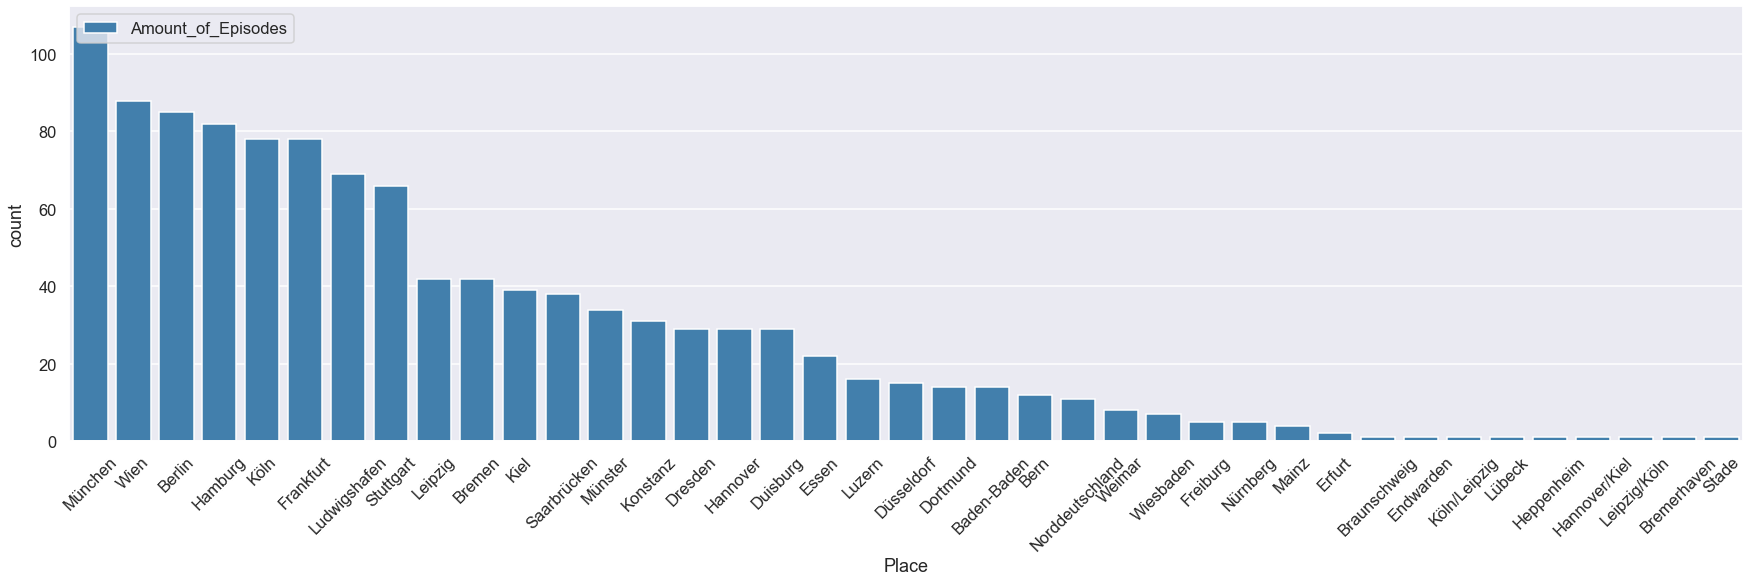

In [38]:
sns.set(font_scale = 1)
sns.set_context("talk")
plt.figure(figsize=(30,8))
sns.countplot('Place', color = "#3182bd", label='Amount_of_Episodes', data=Tatort_list, order = Tatort_list['Place'].value_counts().index)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

This chart confirms our observation from above.

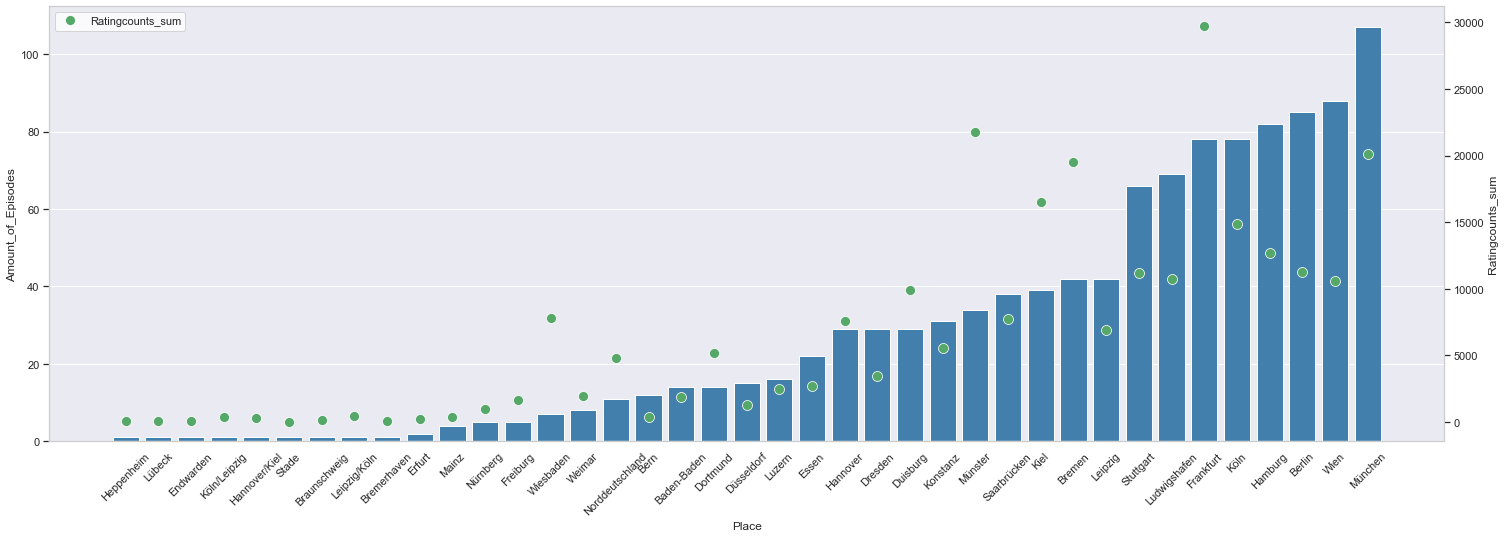

In [39]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Amount_of_Episodes')
ax= sns.barplot(x = 'Place', y = 'Amount_of_Episodes',  label='Amount_of_Episodes', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Place', y = 'Ratingcounts_sum', marker="o",  label='Ratingcounts_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
plt.legend(loc='upper left')
plt.show()

Confirming our observation, Frankfurt reveived the most votes, second is Munich and Third is Bremen. Interesting trend on the right, it seems that Vienna and Berlin are getting less attention from voters even though they make more episodes.

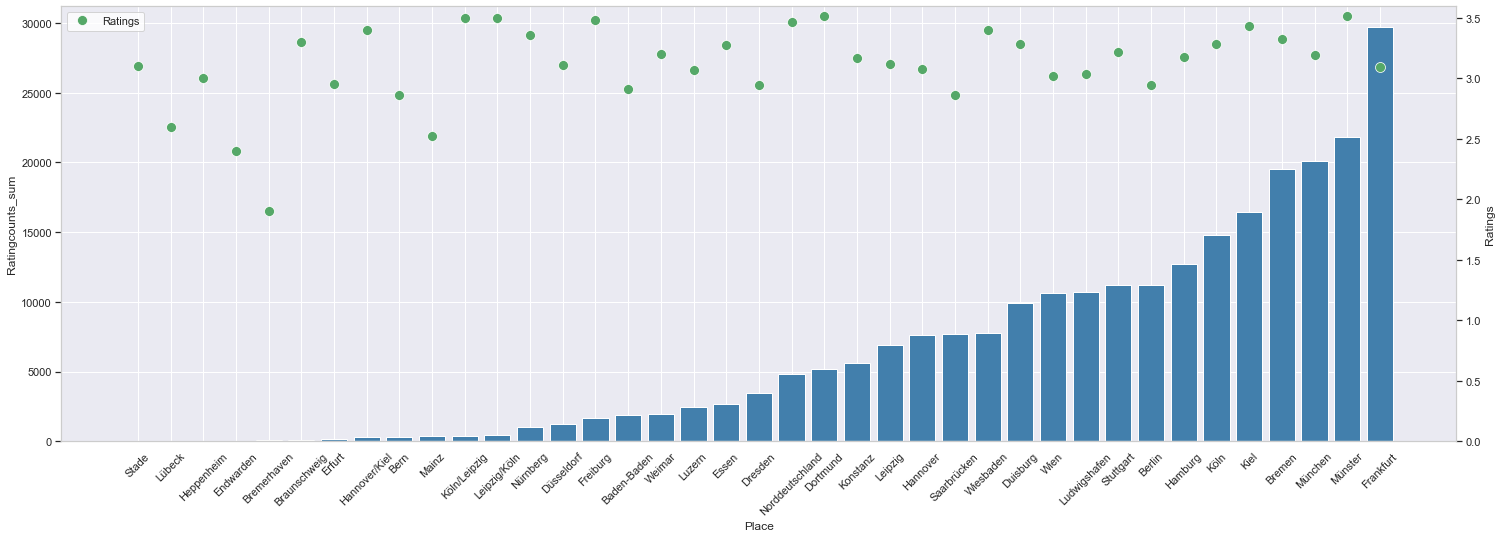

In [40]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Place', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Place', y = 'Ratings', marker="o",  label='Ratings', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Another interesting plot! We see that the cities with the most values also ranging in the area of 3-3.5. People do like the Tatort from Münster and Dortmund. Standing out on the other side is Saarbrücken and Berlin with a lower score. The series with a lower amount of episodes become more spread in the rating.

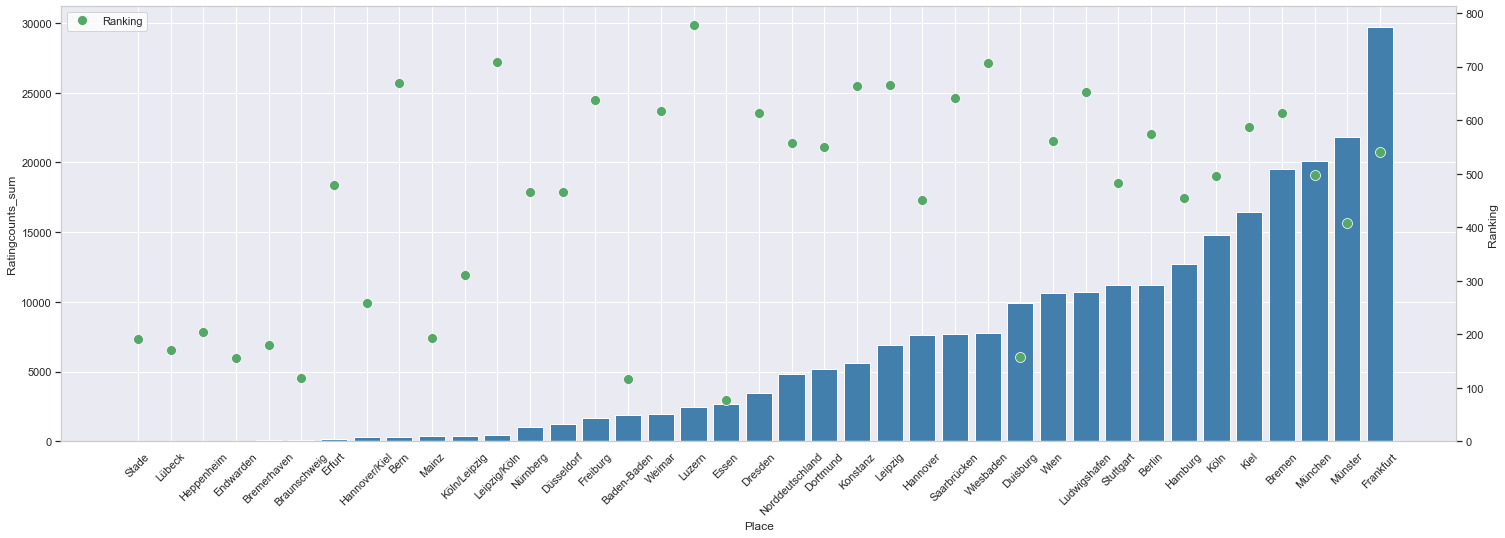

In [41]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Place', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Place', y = 'Ranking', marker="o",  label='Ranking', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

What I see here is that Wiesbaden has a very high ranking. Also people seem to watch Münster and Hannover a lot. 

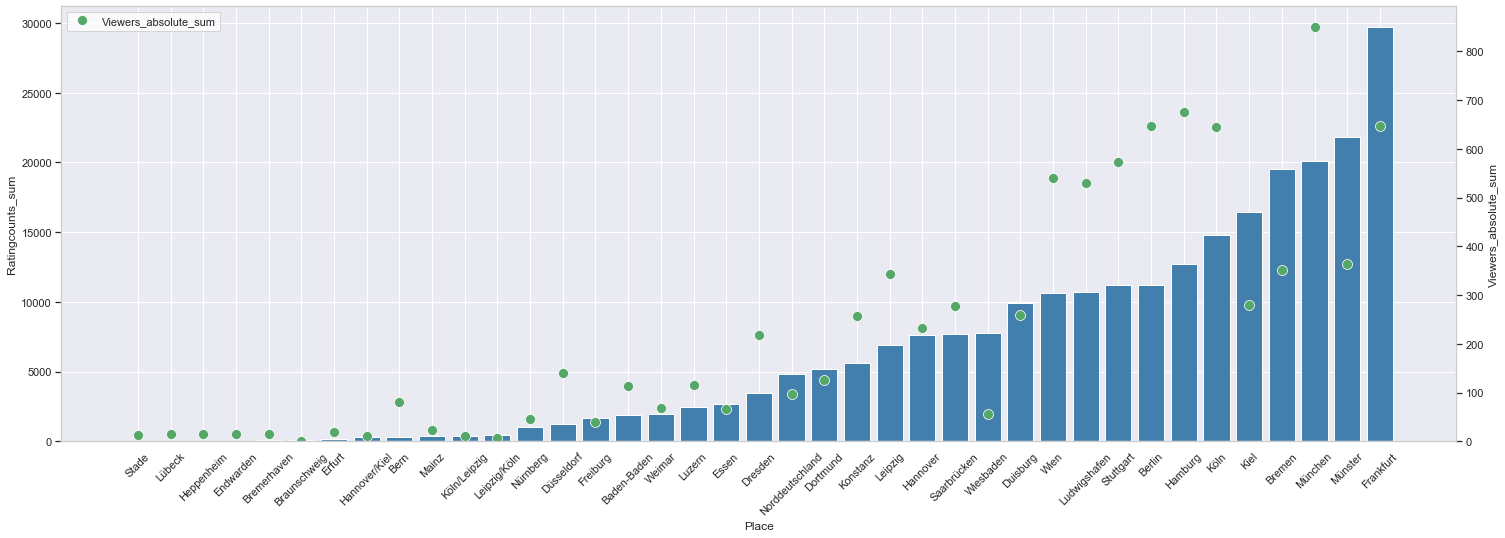

In [42]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Place', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Place', y = 'Viewers_absolute_sum', marker="o",  label='Viewers_absolute_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Comparing viewer and rating sum shows that people seem to watch Munich the most, while Hamburg is on the second place and Frankfurt on the second place.

# Detectives

In [43]:
grouped = Tatort_list.groupby('Detectives').mean()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped_det_sum = Tatort_list.groupby('Detectives').sum().reset_index()
grouped_det_sum_ratings = Tatort_list.groupby('Detectives').sum().reset_index()
grouped_det = Tatort_list.groupby('Detectives').count().reset_index()
grouped = pd.merge(grouped, grouped_det[['Detectives','Number_Episode']], left_on='Detectives', right_on='Detectives')
grouped = pd.merge(grouped, grouped_det_sum[['Detectives','Viewers_absolute']], left_on='Detectives', right_on='Detectives')
grouped = pd.merge(grouped, grouped_det_sum_ratings[['Detectives','Ratingcounts']], left_on='Detectives', right_on='Detectives')
grouped.rename( columns={'Number_Episode_y':'Amount_of_Episodes'}, inplace=True )
grouped.rename( columns={'Number_Episode_x':'Number_Episode'}, inplace=True )
grouped.rename( columns={'Ratingcounts_x':'Ratingcounts'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Amount_of_Episodes', ascending=False).reset_index(drop="True")
grouped.head(10)

,Detectives,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute_mean,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Amount_of_Episodes,Viewers_absolute_sum,Ratingcounts_sum
0,Batic/Leitmayr,625.728395,3.274074,225.864198,13.358025,208.728395,1418.407407,1.000000,1.320988,1.000000,8.383750,24.512346,611.666667,411.135802,64.407407,29.233766,32.740741,81,670.70,18295.0
1,Ballauf/Schenk,697.581081,3.316216,197.743243,12.554054,178.094595,1206.797297,1.000000,1.324324,1.000000,8.850135,25.344595,521.486486,320.067568,44.547945,27.838235,33.162162,74,654.91,14633.0
2,Odenthal/Kopper,649.473684,3.035088,175.105263,11.245614,183.210526,1221.157895,1.000000,1.157895,1.017544,8.114386,23.245614,659.280702,457.333333,33.140351,23.962264,30.350877,57,462.52,9981.0
3,Ehrlicher/Kain,451.545455,2.956818,93.840909,10.613636,191.522727,1301.704545,1.000000,1.227273,1.000000,7.573409,23.020455,703.500000,502.045455,21.295455,15.789474,29.568182,44,333.23,4129.0
4,Stoever/Brockmöller,305.605263,3.189474,108.736842,10.684211,167.605263,1149.842105,1.000000,1.131579,1.000000,10.900625,32.931250,340.562500,184.642857,33.875000,14.086957,31.894737,38,348.82,4132.0
5,Thiel/Boerne,778.176471,3.514706,641.058824,13.852941,165.235294,1125.911765,1.000000,1.647059,1.000000,10.696176,29.476471,407.470588,210.941176,17.470588,12.275862,35.147059,34,363.67,21796.0
6,Lürsen/Stedefreund,781.147059,3.373529,525.676471,14.411765,132.529412,874.323529,1.088235,1.529412,1.000000,8.205882,23.805882,625.823529,423.911765,21.529412,12.766667,33.735294,34,279.00,17873.0
7,Ritter/Stark,660.600000,3.276667,198.900000,10.833333,179.800000,1219.466667,1.000000,1.233333,1.000000,7.956000,22.773333,708.200000,506.200000,49.533333,24.035714,32.766667,30,238.68,5967.0
8,Schimanski/Thanner,191.379310,3.286207,340.931034,9.310345,184.034483,1261.413793,1.000000,1.758621,1.103448,16.228125,43.650000,158.312500,NaN,8.062500,NaN,32.862069,29,259.65,9887.0
9,Brinkmann,331.142857,2.796429,146.178571,9.250000,177.250000,1181.464286,1.000000,1.071429,1.000000,10.056154,29.892308,563.884615,455.818182,40.307692,25.833333,27.964286,28,261.46,4093.0


The list by Detectives shows some interesting facts:

    -The detectives with the most episodes were Baltic/Leitmeyer from Munich
    -The absolute amount of viewers is 671 million followed by Ballauf/Schenk with 655 million viewers.
    -On average the most viewers were at Schimanski/Thanner with 16.22 per Episode
    -Highest average viewer % is at Schimanski/Thanner with 44%
    -The highest average rating is at Thiel/Börne with 3.51 of 5
    -The highest amount of ratings is again at Thiel/Börne with 21,796

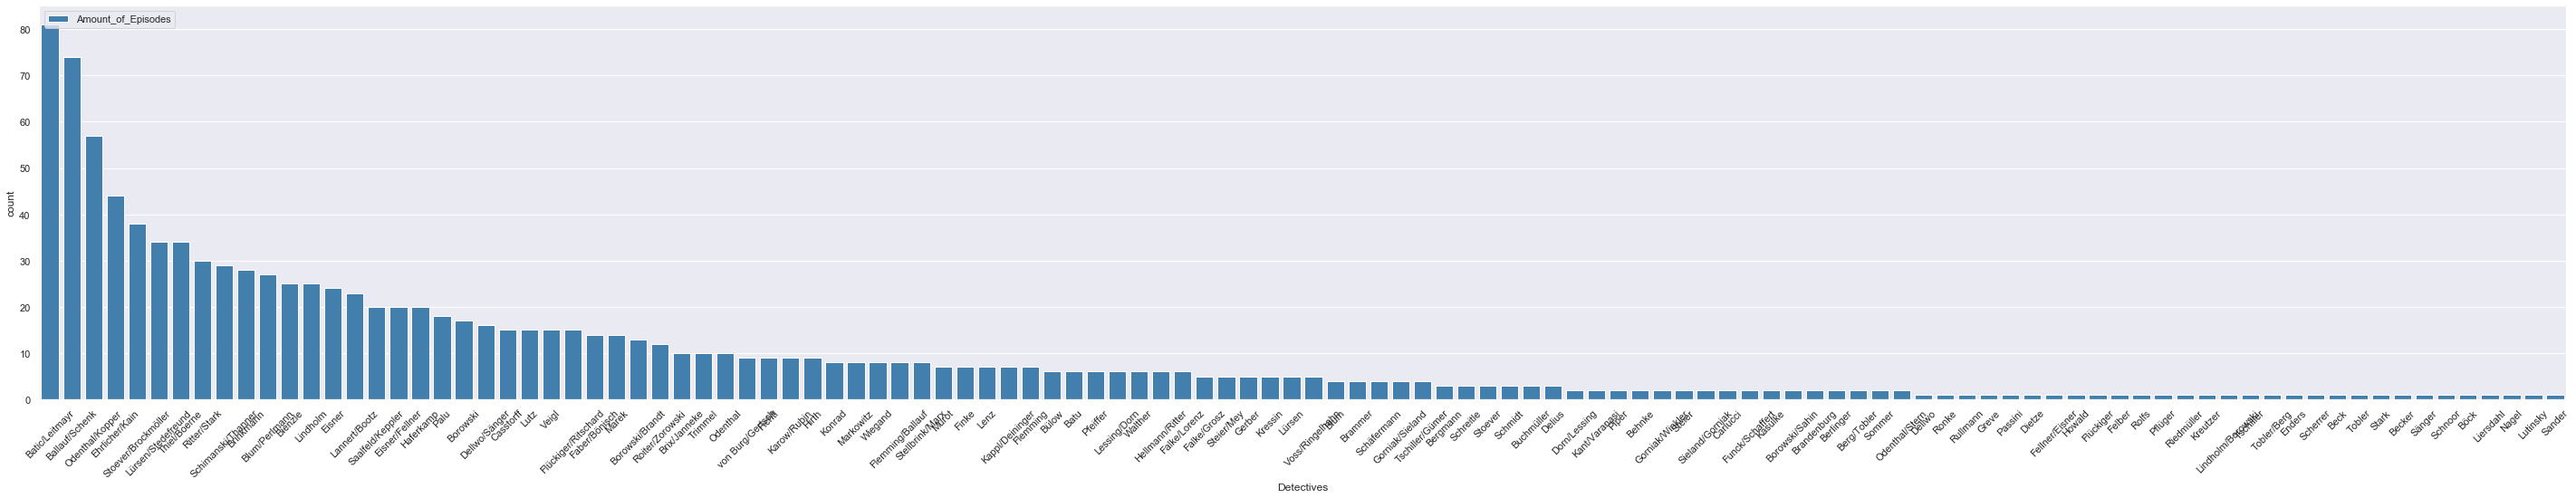

In [44]:
#Click on the image to zoom in
sns.set(font_scale = 1)
plt.figure(figsize=(50,8))
sns.countplot('Detectives', color = "#3182bd",  label='Amount_of_Episodes', data=Tatort_list, order = Tatort_list['Detectives'].value_counts().index)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

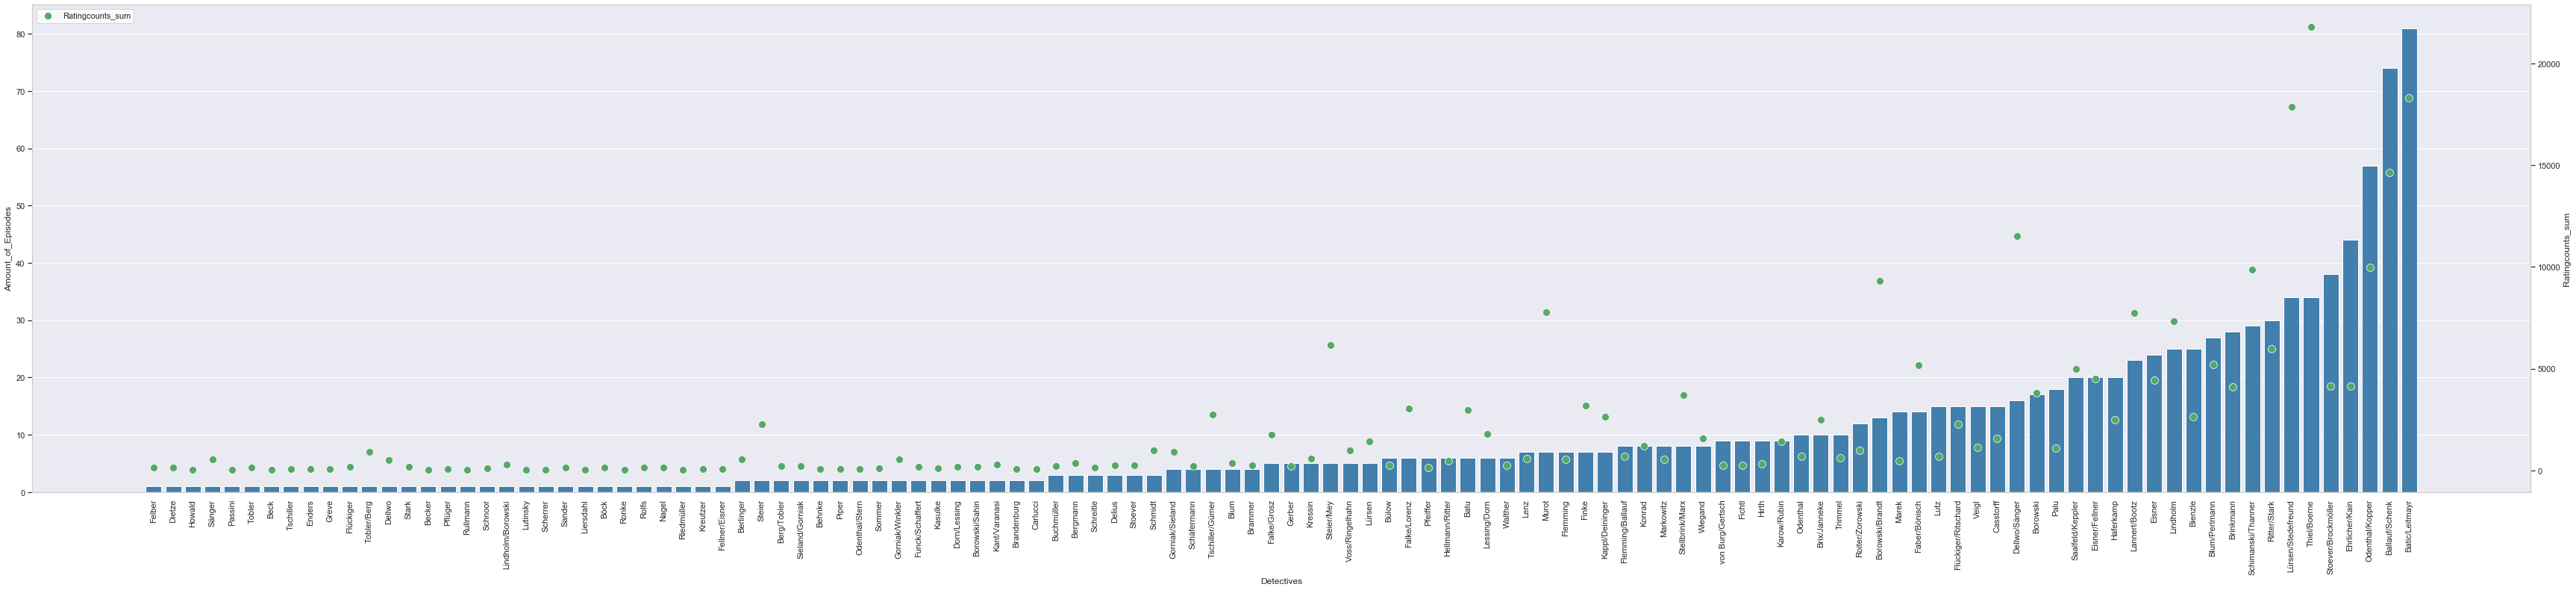

In [45]:
#Click on the image to zoom in
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(60,12))
plt.xticks(rotation=90)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Amount_of_Episodes')
ax= sns.barplot(x = 'Detectives', y = 'Amount_of_Episodes',  label='Amount_of_Episodes', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Detectives', y = 'Ratingcounts_sum', marker="o",  label='Ratingcounts_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
plt.legend(loc='upper left')
plt.show()

Interestingly, the detectives with not the highest amount of episodes received most votes. Examples are Thiel/Börne

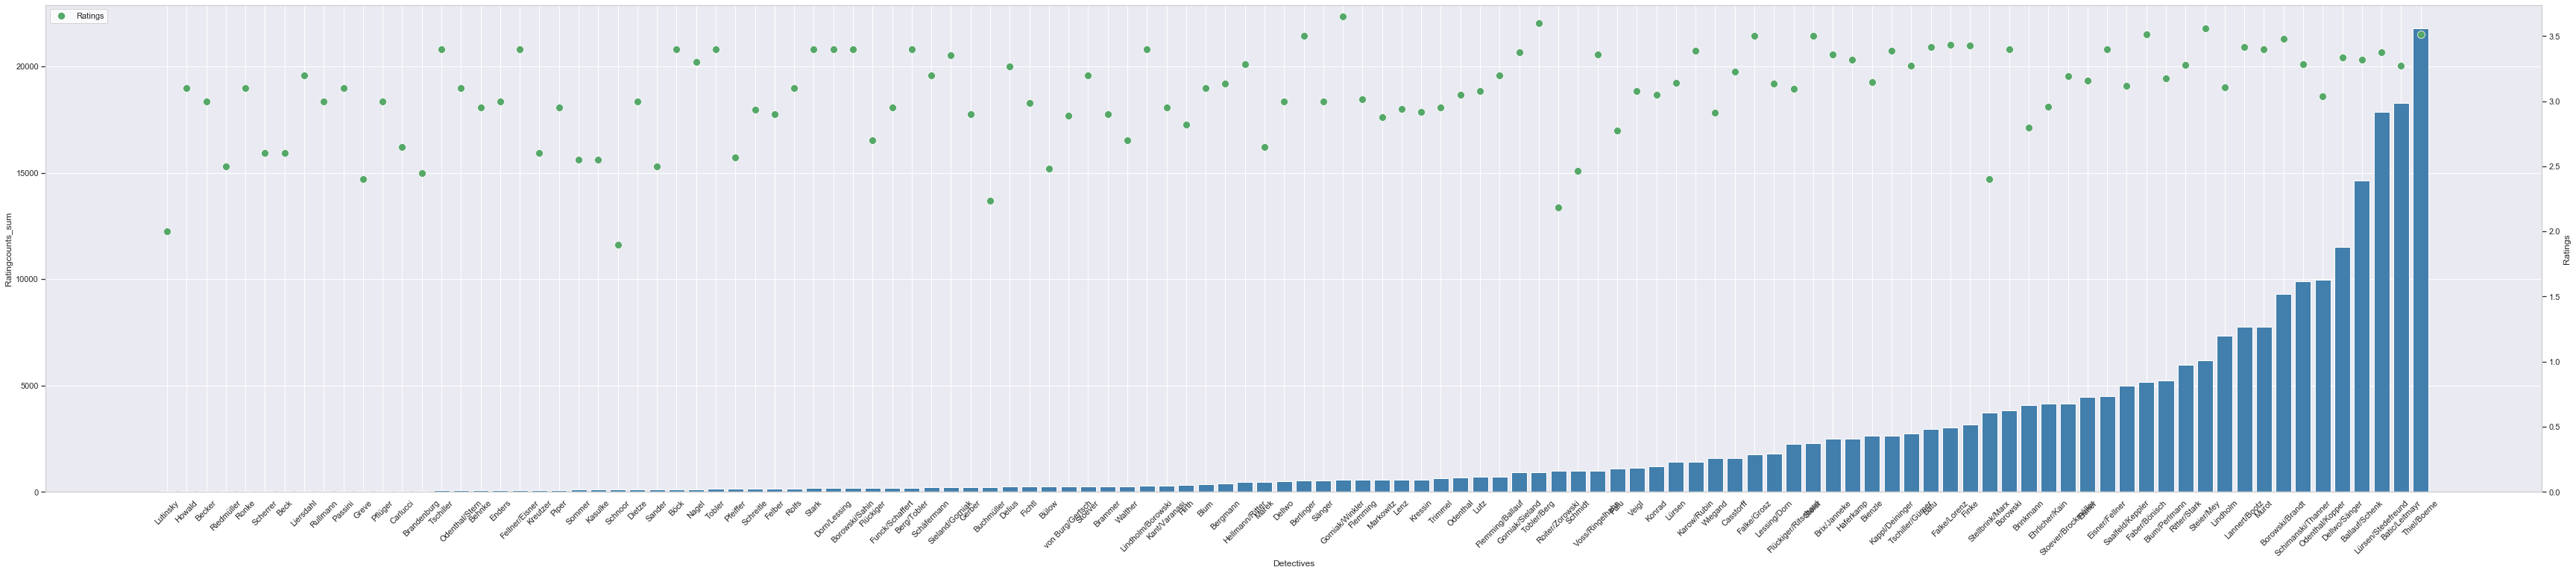

In [46]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(60,12))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Detectives', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Detectives', y = 'Ratings', marker="o",  label='Ratings', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Of the top detectives, Odenthal/Kopper stand out with a lower Rating to # of episodes rating. Thiel/Börne enjoy the highest rating and # of episodes.

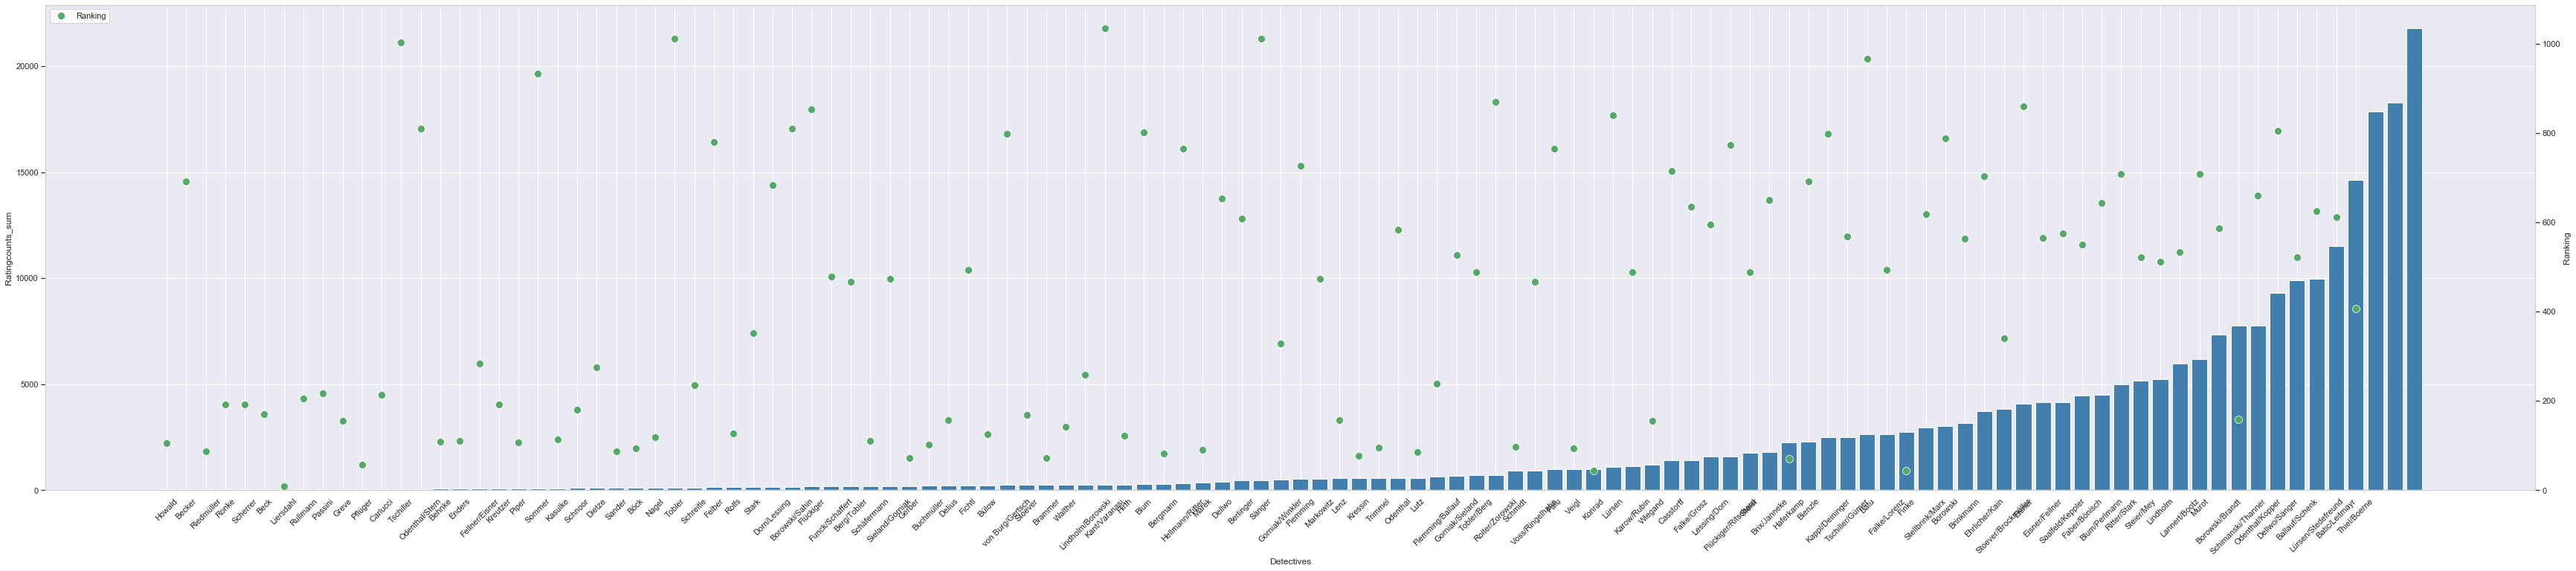

In [47]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(60,12))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Detectives', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Detectives', y = 'Ranking', marker="o",  label='Ranking', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Investigating ranking vs ratingcounts shows that Schimanski/Thanner seem to be liked a lot. They got a high amount of rating and a high ranking.

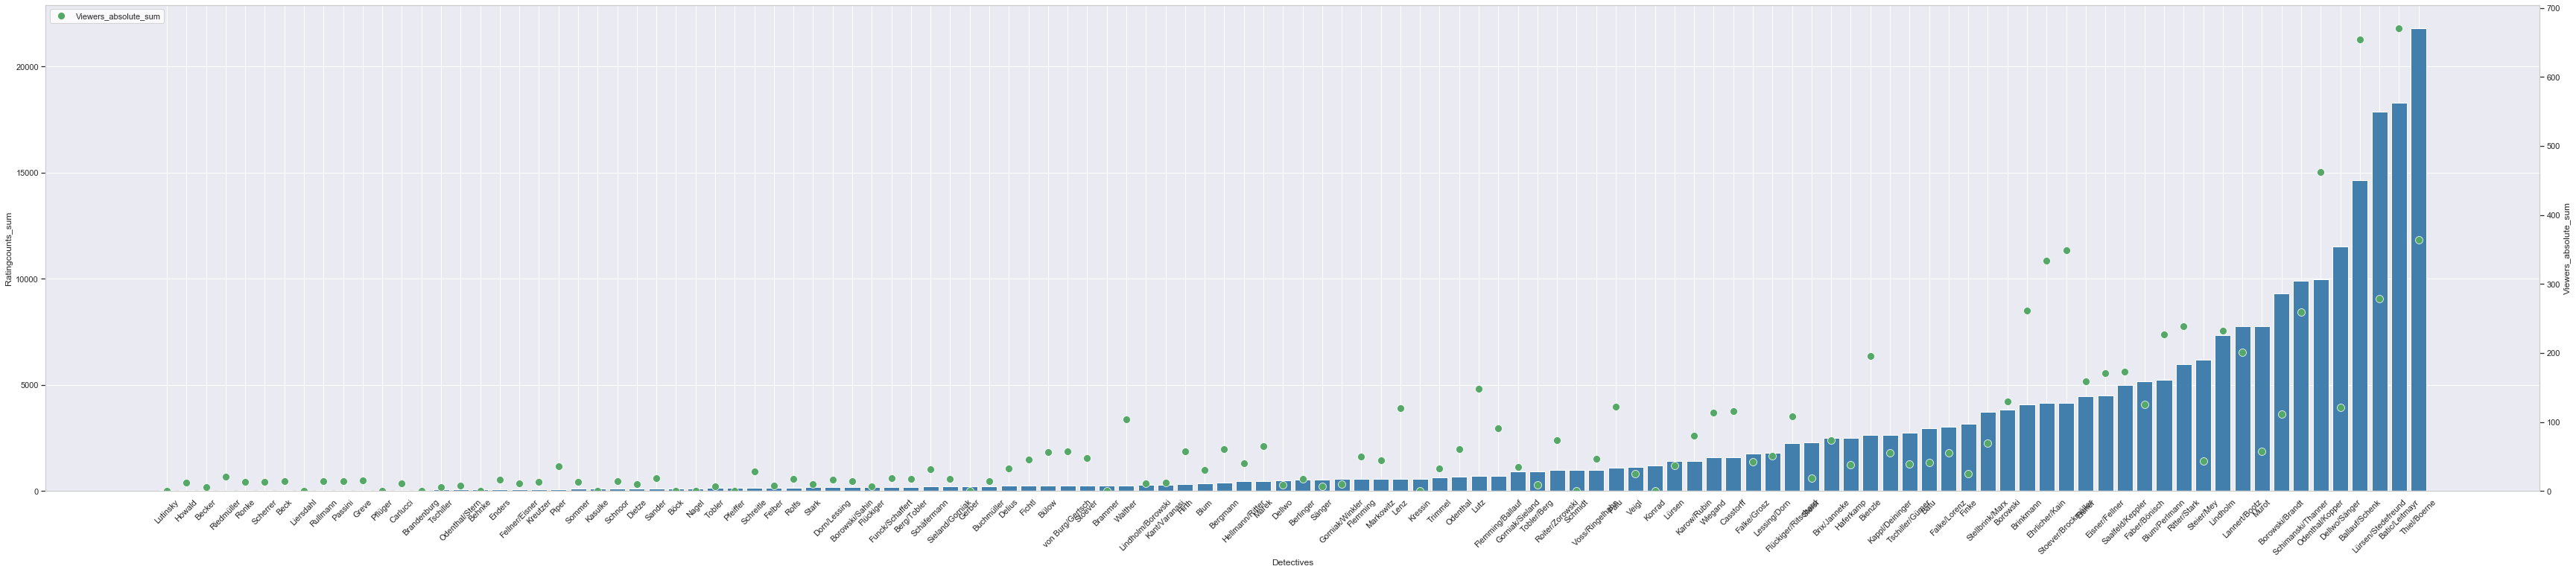

In [48]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 10})
plt.figure(figsize=(60,12))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Detectives', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Detectives', y = 'Viewers_absolute_sum', marker="o",  label='Viewers_absolute_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Watchers seem to like Tiel/Börne a lot. Batic and Leitmeyer seem to get a higher amount of viewers even though they received lower amount of votes. Lürsen/Stedefreund was third with a large voting rate but less viewers than Munich and Münster.

# Time

In [49]:
grouped = Tatort_list.groupby('Year').mean()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped_time_sum = Tatort_list.groupby('Year').sum().reset_index()
grouped_time_sum_ratings = Tatort_list.groupby('Year').sum().reset_index()
grouped_time = Tatort_list.groupby('Year').count().reset_index()
grouped = pd.merge(grouped, grouped_time[['Year','Number_Episode']], left_on='Year', right_on='Year')
grouped = pd.merge(grouped, grouped_time_sum[['Year','Viewers_absolute']], left_on='Year', right_on='Year')
grouped = pd.merge(grouped, grouped_time_sum_ratings[['Year','Ratingcounts']], left_on='Year', right_on='Year')
grouped.rename( columns={'Number_Episode_y':'Amount_of_Episodes'}, inplace=True )
grouped.rename( columns={'Number_Episode_x':'Number_Episode'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Year', ascending=False).reset_index(drop="True")
grouped.head(10)

,Year,Number_Episode,Ratings,Ratingcounts_x,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute_mean,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Amount_of_Episodes,Viewers_absolute_sum,Ratingcounts_sum
0,2019,1090.0,3.408000,143.560000,12.120000,144.400000,986.760000,1.000000,1.520000,1.000000,9.061364,26.181818,466.454545,265.409091,15.500000,6.437500,34.080000,25,199.35,3589.0
1,2018,1059.0,3.421622,148.027027,12.810811,184.081081,1263.756757,1.000000,1.486486,1.000000,8.647838,25.067568,546.567568,345.351351,22.162162,10.483871,34.216216,37,319.97,5477.0
2,2017,1023.0,3.262857,139.885714,12.485714,176.600000,1177.742857,1.000000,1.600000,1.057143,8.865714,25.091429,554.057143,353.142857,23.028571,11.296296,32.628571,35,310.30,4896.0
3,2016,987.0,3.351351,309.378378,13.621622,197.297297,1268.135135,1.027027,1.297297,1.054054,8.973784,24.956757,574.432432,373.864865,26.277778,12.545455,33.513514,37,332.03,11447.0
4,2015,948.5,3.282500,428.500000,15.175000,171.075000,1114.900000,1.000000,1.425000,1.000000,9.494000,26.752500,442.850000,242.100000,15.950000,6.035714,32.825000,40,379.76,17140.0
5,2014,910.5,3.180556,456.000000,14.111111,176.500000,1171.916667,1.000000,1.388889,1.000000,9.464167,26.638889,441.277778,240.388889,17.361111,6.533333,31.805556,36,340.71,16416.0
6,2013,874.5,3.188889,531.027778,13.055556,225.527778,1529.944444,1.000000,1.250000,1.000000,9.321667,26.047222,478.083333,276.722222,20.611111,7.571429,31.888889,36,335.58,19117.0
7,2012,839.0,3.351429,519.857143,14.971429,197.200000,1339.714286,1.028571,1.342857,1.000000,8.858857,24.468571,589.200000,387.571429,30.787879,17.500000,33.514286,35,310.06,18195.0
8,2011,803.5,3.227778,410.750000,13.666667,159.083333,1070.166667,1.000000,1.305556,1.027778,8.412500,23.488889,653.944444,452.083333,35.388889,19.272727,32.277778,36,302.85,14787.0
9,2010,768.0,3.242857,432.171429,12.942857,170.542857,1146.257143,1.000000,1.428571,1.000000,8.548286,23.725714,633.171429,431.285714,34.257143,14.939394,32.428571,35,299.19,15126.0


The list by Place shows some interesting facts:
From the last 10 years:

    -The year with the most episodes was 2015 followed 2016
    -The highest absolute amount of viewers was 380 million in 2015 followed by 341 million in 2014.
    -On average the most viewers were 2014 and 2015 = 9.5 million
    -Highest average viewer % was in 2015 with 27%.
    -The highest average rating is in 2018 with 3.42 out of 5
    -The highest amount of ratings was for episodes from 2013 - 19,117

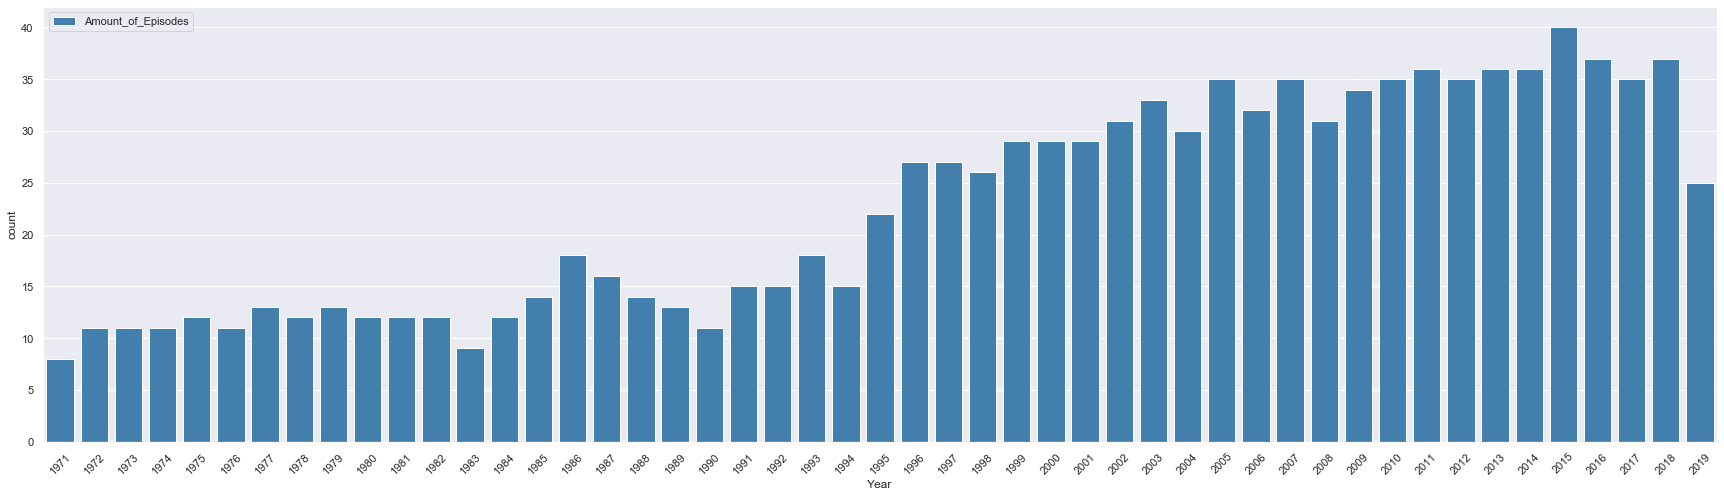

In [50]:
sns.set(font_scale = 1)
plt.figure(figsize=(30,8))
sns.countplot('Year', color = "#3182bd",  label='Amount_of_Episodes', data=Tatort_list)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

Interesting observation. After the reunification of Germany, Tatort production increased by more than 100%. Please keep in mind, as mentioned before that:

    -Swiss episodes joined the pool from 1990-2001 and again in 2011
    -Eastern Germany had an own show called Polizeiruf 110. It is still being broadcasted but the Tatort city was increased to cities in Eastern Germany such as Dresden.

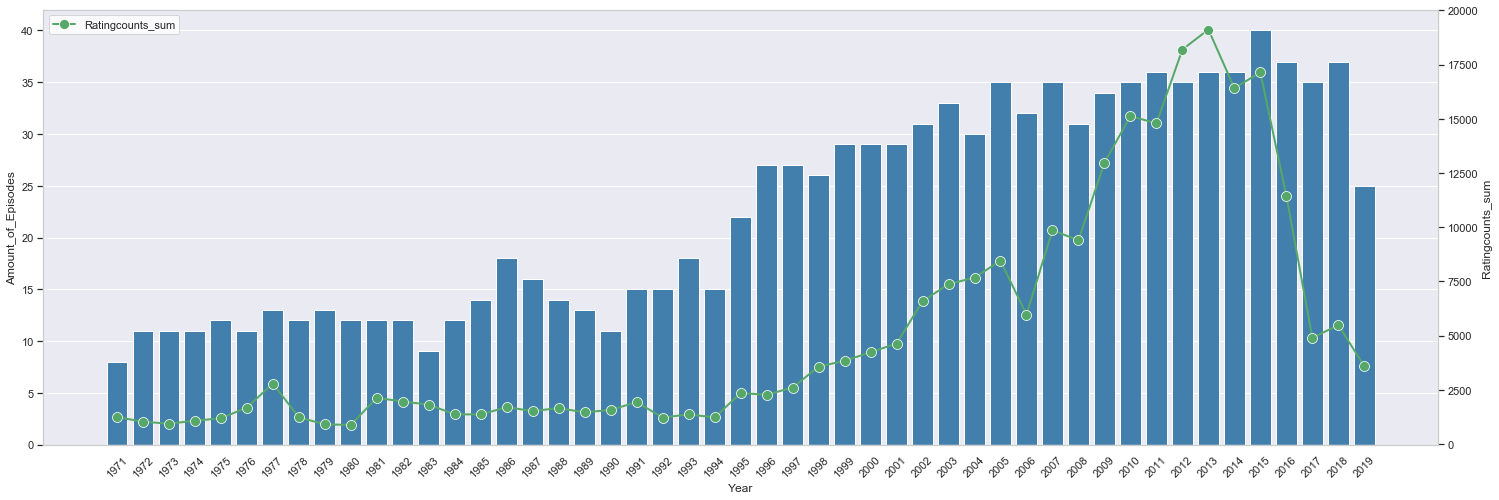

In [51]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 2, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Year')
ax= sns.barplot(x = 'Year', y = 'Amount_of_Episodes',  label='Amount_of_Episodes', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Year', y = 'Ratingcounts_sum', marker="o",  label='Ratingcounts_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
plt.legend(loc='upper left')
plt.show()

With the amount of episodes, the amount of votes increased. But the curve starts to decline in 2016, why? It is due to the fact that many Tatort episodes will be sent again to a later date, mostly during the summer break or to fill some airtime.

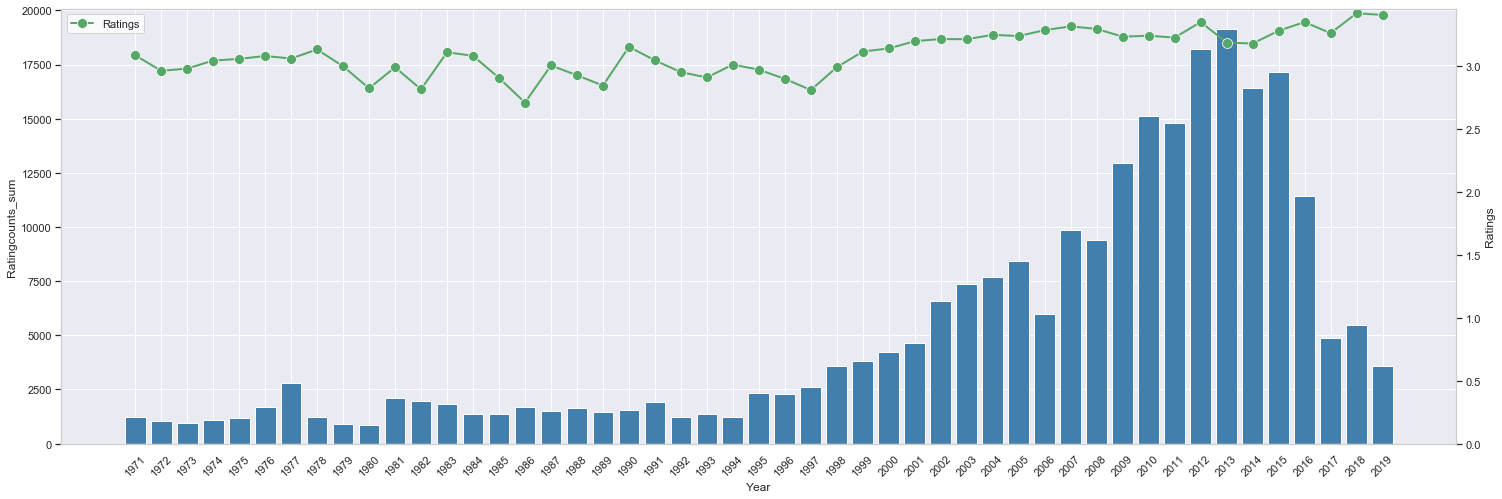

In [52]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 2, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Year')
ax= sns.barplot(x = 'Year', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Year', y = 'Ratings', marker="o",  label='Ratings', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Here we see the same observation just from a different angle. The worst rated year was 1987, the best rated (full) year was 2018. On average the rating is increasing over the years.

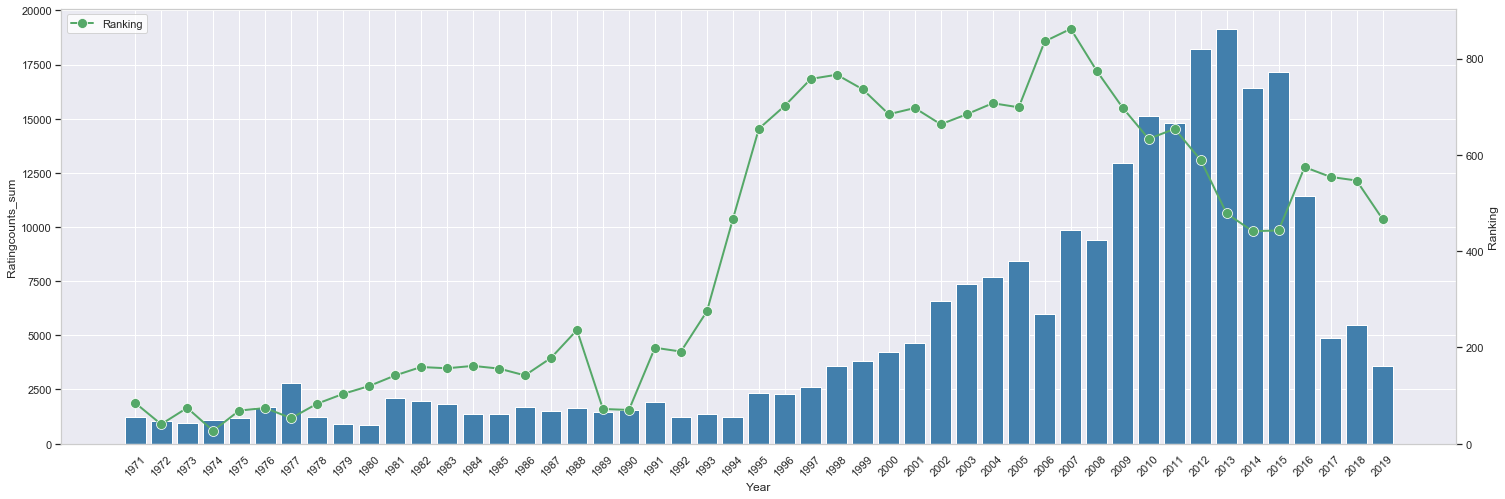

In [53]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 2, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Year')
ax= sns.barplot(x = 'Year', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Year', y = 'Ranking', marker="o",  label='Ranking', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

We see a steep increase in ranking after 1990, that is due to the reunification of Germany. Afterwards the ranking ranges between 700 and 800. In 2016 it increases, we will see below why. Then the ranking decreased below 500 which is a sign that more people are watching Tatort.

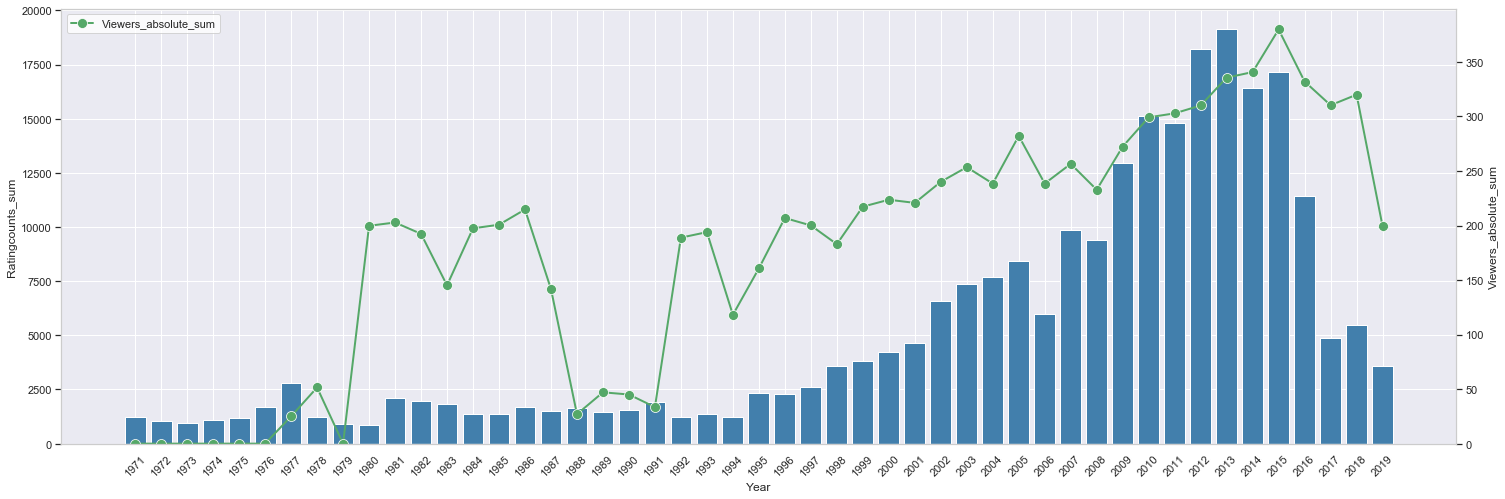

In [54]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 2, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Year')
ax= sns.barplot(x = 'Year', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Year', y = 'Viewers_absolute_sum', marker="o",  label='Viewers_absolute_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

There seems to be an error in the data between 1988 and 1991. If that is true than not many people payed attention to Tatort while celebrating reunification of Germany :). Afterwards we see an increase in viewers and voters. Highest amount of viewers were in 2015. Lets have a look on the averages below.

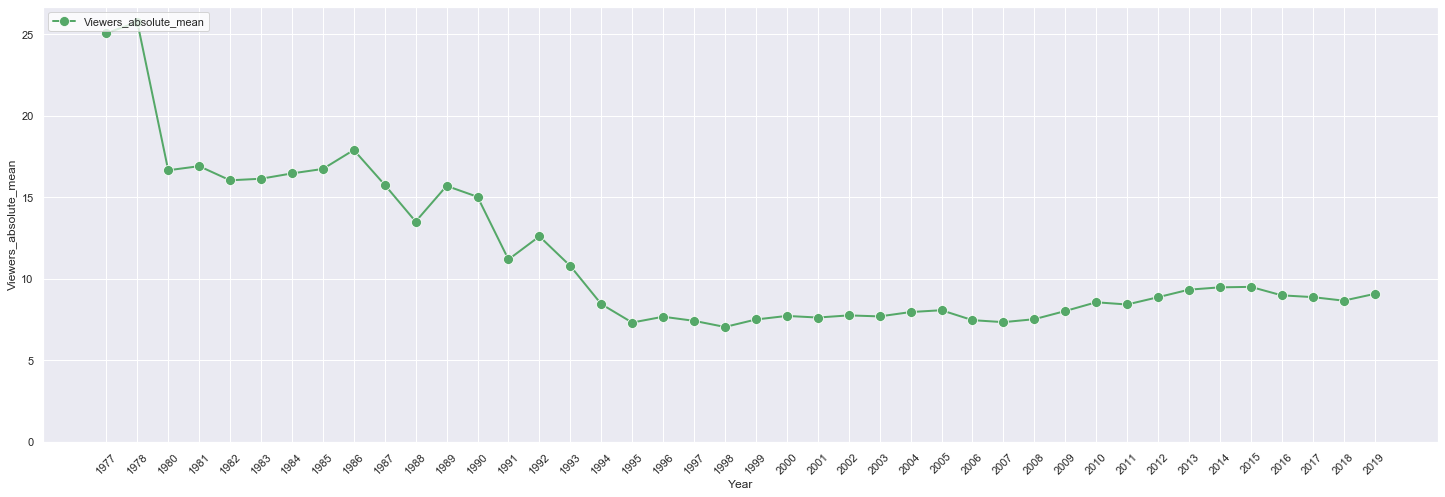

In [55]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 2, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Year')
ax = sns.lineplot(x = 'Year', y = 'Viewers_absolute_mean', marker="o",  label='Viewers_absolute_mean', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0, None))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Interesting, the averages decreased from 1977 continously until 2000 when it starts to increase slowly.

In [56]:
grouped = Tatort_list.groupby('Month').mean()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped_time_sum = Tatort_list.groupby('Month').sum().reset_index()
grouped_time_sum_ratings = Tatort_list.groupby('Month').sum().reset_index()
grouped_time = Tatort_list.groupby('Month').count().reset_index()
grouped = pd.merge(grouped, grouped_time[['Month','Number_Episode']], left_on='Month', right_on='Month')
grouped = pd.merge(grouped, grouped_time_sum[['Month','Viewers_absolute']], left_on='Month', right_on='Month')
grouped = pd.merge(grouped, grouped_time_sum_ratings[['Month','Ratingcounts']], left_on='Month', right_on='Month')
grouped.rename( columns={'Number_Episode_y':'Amount_of_Episodes'}, inplace=True )
grouped.rename( columns={'Number_Episode_x':'Number_Episode'}, inplace=True )
grouped.rename( columns={'Ratingcounts_x':'Ratingcounts'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Month', ascending=False).reset_index(drop="True")
grouped

,Month,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute_mean,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Amount_of_Episodes,Viewers_absolute_sum,Ratingcounts_sum
0,12,562.886598,3.147423,285.154639,12.391753,173.278351,1173.762887,1.010309,1.381443,1.010309,8.645122,26.892135,648.202247,554.675676,36.460674,23.196970,31.474227,97,708.90,27660.0
1,11,576.362637,3.178022,238.791209,12.296703,169.516484,1140.296703,1.000000,1.307692,1.010989,9.529103,28.816279,515.593023,388.068493,28.152941,13.000000,31.780220,91,743.27,21730.0
2,10,551.570093,3.128972,256.785047,11.691589,169.981308,1157.009346,1.009346,1.420561,1.028037,9.380000,28.864356,539.554455,426.345238,32.752475,19.223684,31.289720,107,872.34,27476.0
3,09,512.804124,3.156701,227.412371,12.979381,180.092784,1222.154639,1.000000,1.319588,1.041237,9.449012,31.473913,489.760870,418.623188,29.571429,19.393443,31.567010,97,765.37,22059.0
4,08,503.078652,3.106742,172.651685,12.674157,156.573034,1057.044944,1.000000,1.213483,1.022472,9.473478,32.332099,447.753086,373.949153,24.925000,17.600000,31.067416,89,653.67,15366.0
5,07,427.727273,2.993939,155.878788,11.666667,174.469697,1185.045455,1.000000,1.212121,1.000000,8.602778,30.559677,518.064516,457.695652,29.483871,16.341463,29.939394,66,464.55,10288.0
6,06,523.450704,3.118310,194.929577,12.366197,185.267606,1255.070423,1.000000,1.281690,1.000000,9.143115,30.435714,484.857143,400.566038,24.057143,16.520833,31.183099,71,557.73,13840.0
7,05,564.719626,3.166355,215.897196,12.037383,161.766355,1093.317757,1.009346,1.327103,1.000000,8.884409,28.150000,536.470000,409.411765,29.300000,16.716049,31.663551,107,826.25,23101.0
8,04,558.910000,3.256000,254.990000,11.670000,182.340000,1226.270000,1.000000,1.230000,1.000000,9.057442,28.707447,534.521277,417.820513,30.691489,18.579710,32.560000,100,778.94,25499.0
9,03,591.211111,3.188889,263.733333,11.100000,191.466667,1292.577778,1.000000,1.288889,1.000000,9.744512,29.360227,502.056818,372.186667,27.068182,16.396825,31.888889,90,799.05,23736.0


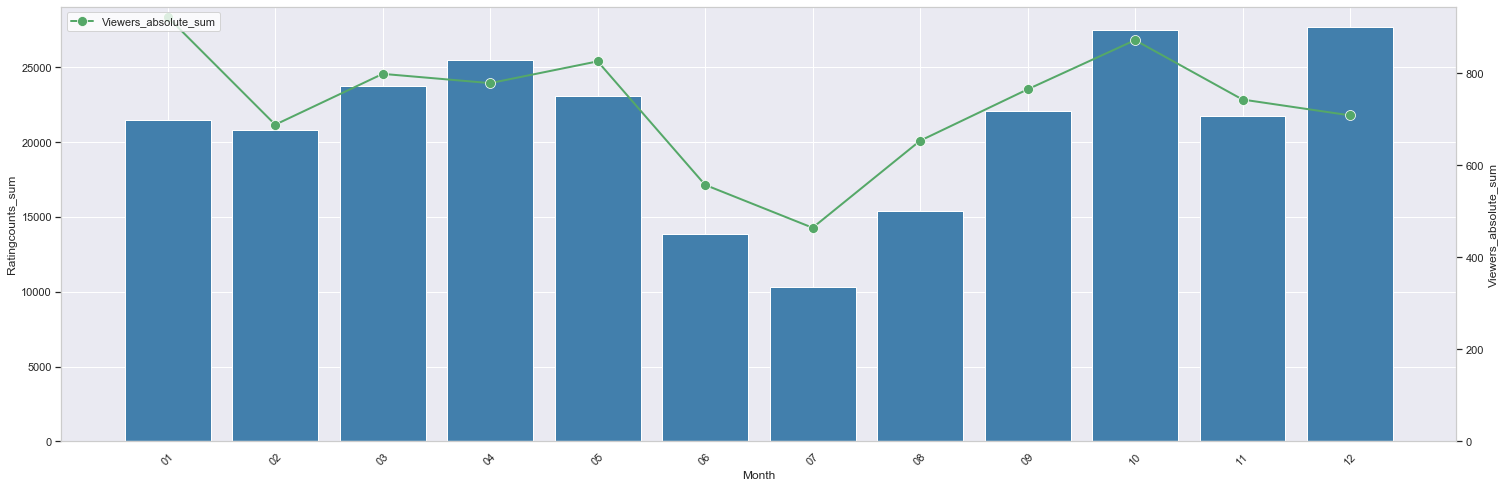

In [57]:
sns.set(font_scale = 1.2)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 2, 'lines.markersize': 10})
plt.figure(figsize=(25,8))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Month')
ax= sns.barplot(x = 'Month', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Month', y = 'Viewers_absolute_sum', marker="o",  label='Viewers_absolute_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Lets have finally a look on the release date by month. There seems to be a drop in Summer, maybe it is because....

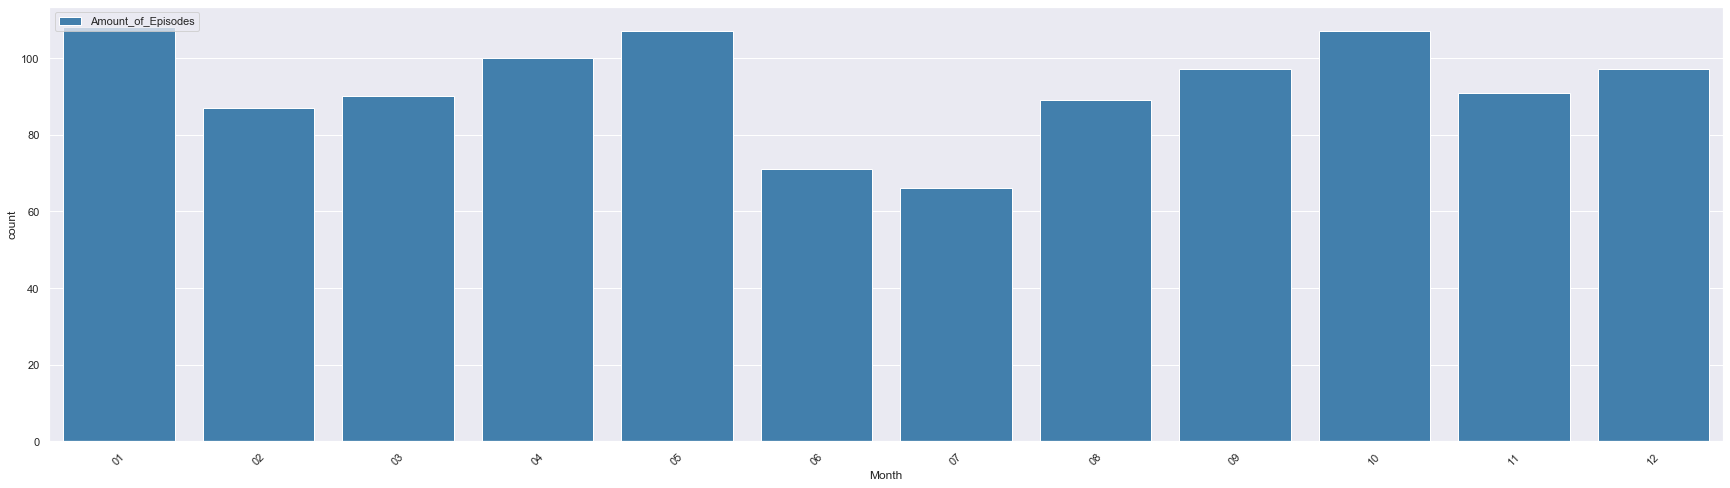

In [58]:
sns.set(font_scale = 1)
plt.figure(figsize=(30,8))
sns.countplot('Month', color = "#3182bd",  label='Amount_of_Episodes', data=Tatort_list)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

Exactly! There are not so many released episodes in summer. In fact, usually there is a summer break for Tatort productions.

# Episodes

In [4]:
grouped = Tatort_list.groupby('Title').mean()
grouped_title_sum = Tatort_list.groupby('Title').sum().reset_index()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped = pd.merge(grouped, Tatort_list[['Title','Detectives','Place']], left_on='Title', right_on='Title')
grouped_title_sum_ratings = Tatort_list.groupby('Title').sum().reset_index()
grouped = pd.merge(grouped, grouped_title_sum[['Title','Viewers_absolute']], left_on='Title', right_on='Title')
grouped = pd.merge(grouped, grouped_title_sum_ratings[['Title','Ratingcounts']], left_on='Title', right_on='Title')
grouped.rename( columns={'Ratingcounts_x':'Ratingcounts'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Ratings', ascending=False).reset_index(drop="True")
grouped.head(10)

,Title,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,...,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Detectives,Place,Viewers_absolute_sum,Ratingcounts_sum
0,Im Schmerz geboren,920.0,4.0,3470.0,19.0,366.0,2268.0,1.0,1.0,1.0,...,26.0,426.0,224.0,2.0,2.0,40.0,Murot,Wiesbaden,9.29,3470.0
1,Reifezeugnis,73.0,3.8,1810.0,11.0,461.0,3238.0,1.0,1.0,1.0,...,67.0,14.0,NaN,2.0,NaN,38.0,Finke,Kiel,25.05,1810.0
2,Weil sie böse sind,751.0,3.8,2556.0,10.0,156.0,1041.0,1.0,1.0,1.0,...,20.2,913.0,711.0,59.0,4.0,38.0,Dellwo/Sänger,Frankfurt,7.54,2556.0
3,Das Nest,1092.0,3.8,477.0,11.0,153.0,1070.0,1.0,1.0,1.0,...,27.7,329.0,127.0,7.0,7.0,38.0,Gorniak/Winkler,Dresden,9.67,477.0
4,Borowski und der Himmel über Kiel,933.0,3.8,2050.0,20.0,127.0,824.0,1.0,1.0,1.0,...,28.5,296.0,95.0,8.0,NaN,38.0,Borowski/Brandt,Kiel,10.67,2050.0
5,Zorn Gottes,980.0,3.7,1046.0,11.0,100.0,661.0,1.0,1.0,1.0,...,23.5,647.0,445.0,8.0,8.0,37.0,Falke/Grosz,Norddeutschland,8.55,1046.0
6,Es ist böse,836.0,3.7,1359.0,14.0,133.0,913.0,1.0,1.0,1.0,...,25.8,453.0,251.0,33.0,5.0,37.0,Steier/Mey,Frankfurt,9.50,1359.0
7,Die Wiederkehr,939.0,3.7,2149.0,13.0,114.0,736.0,1.0,2.0,1.0,...,28.9,284.0,83.0,4.0,NaN,37.0,Lürsen/Stedefreund,Bremen,10.61,2149.0
8,Das Böse,552.0,3.7,1520.0,11.0,132.0,841.0,1.0,1.0,1.0,...,20.3,908.0,706.0,58.0,4.0,37.0,Dellwo/Sänger,Frankfurt,7.17,1520.0
9,Das Haus am Ende der Straße,937.0,3.7,1591.0,15.0,307.0,2000.0,1.0,2.0,1.0,...,25.3,489.0,287.0,35.0,7.0,37.0,Steier,Frankfurt,9.37,1591.0


Lets focus on the best 10 episodes here:

    -Best episode was "Im Schmerz geboren"
    -This episode from Wiesbaden has the highest rating and got most amount of votes.
    -The episode with the highest amount of viewers was Reifezeugnis from Kiel
    -This episode received also best viewers %

We will deep dive later in the recommendations section again into the best episodes.

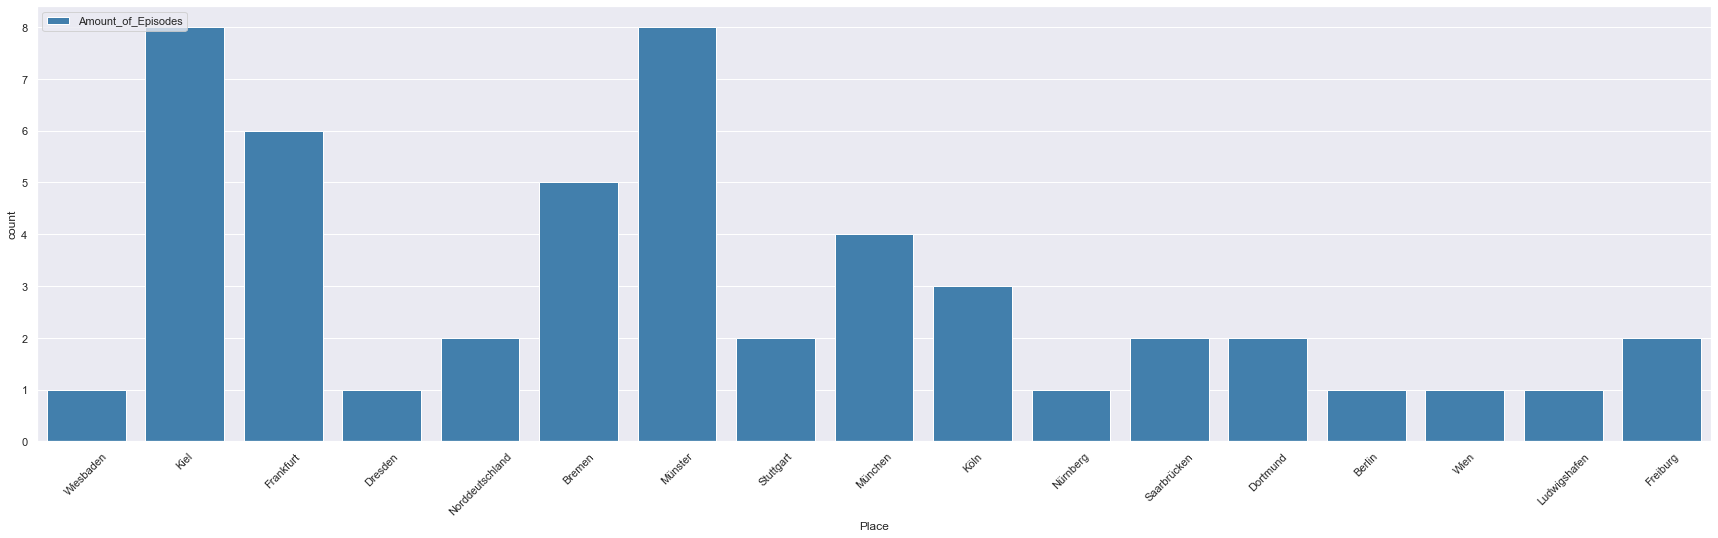

In [5]:
best_50 = grouped.head(50)
sns.set(font_scale = 1)
plt.figure(figsize=(30,8))
sns.countplot('Place', color = "#3182bd",  label='Amount_of_Episodes', data=best_50)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

From the 50 best episodes, 8 come from Münster; 8 from Kiel and 6 from Frankfurt and 5 from Bremen.

## Director

In [61]:
grouped = Tatort_list.groupby('Director').mean()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped_director_sum = Tatort_list.groupby('Director').sum().reset_index()
grouped_director_sum_ratings = Tatort_list.groupby('Director').sum().reset_index()
grouped_director = Tatort_list.groupby('Director').count().reset_index()
grouped = pd.merge(grouped, grouped_director[['Director','Number_Episode']], left_on='Director', right_on='Director')
grouped = pd.merge(grouped, grouped_director_sum[['Director','Viewers_absolute']], left_on='Director', right_on='Director')
grouped = pd.merge(grouped, grouped_director_sum_ratings[['Director','Ratingcounts']], left_on='Director', right_on='Director')
grouped.rename( columns={'Number_Episode_y':'Amount_of_Episodes'}, inplace=True )
grouped.rename( columns={'Number_Episode_x':'Number_Episode'}, inplace=True )
grouped.rename( columns={'Ratingcounts_x':'Ratingcounts'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Amount_of_Episodes', ascending=False).reset_index(drop="True")
grouped.head(10)

,Director,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute_mean,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Amount_of_Episodes,Viewers_absolute_sum,Ratingcounts_sum
0,Hartmut Griesmayr,373.115385,3.176923,104.038462,10.192308,184.461538,1257.038462,1.0,1.307692,1.000000,9.716957,30.346154,482.038462,402.631579,28.884615,18.866667,31.769231,26,223.49,2705.0
1,Hajo Gies,332.809524,3.247619,282.952381,10.428571,191.428571,1308.000000,1.0,1.571429,1.047619,10.860000,34.612500,441.250000,543.500000,19.500000,17.857143,32.476190,21,152.04,5942.0
2,Thomas Jauch,741.904762,3.352381,339.952381,14.285714,184.333333,1233.857143,1.0,1.285714,1.000000,9.194286,25.823810,532.619048,332.238095,26.526316,9.777778,33.523810,21,193.08,7139.0
3,Kaspar Heidelbach,622.950000,3.370000,289.600000,12.050000,189.250000,1284.800000,1.0,1.600000,1.000000,9.837000,27.310000,447.050000,247.200000,29.250000,16.555556,33.700000,20,196.74,5792.0
4,Thomas Bohn,602.944444,3.155556,94.388889,8.722222,169.722222,1180.500000,1.0,1.055556,1.000000,8.130000,23.105882,670.058824,468.058824,44.294118,23.000000,31.555556,18,138.21,1699.0
5,Florian Baxmeyer,891.176471,3.447059,612.117647,12.882353,139.647059,926.647059,1.0,1.823529,1.000000,8.701765,25.135294,519.941176,318.117647,19.294118,12.833333,34.470588,17,147.93,10406.0
6,Theo Mezger,102.200000,3.100000,50.066667,12.400000,187.133333,1247.066667,1.0,1.000000,1.000000,18.533750,55.333333,86.000000,NaN,8.800000,NaN,31.000000,15,148.27,751.0
7,Peter Schulze-Rohr,137.785714,3.064286,67.357143,11.857143,168.714286,1151.714286,1.0,1.000000,1.000000,9.055000,46.446154,227.846154,361.000000,17.153846,12.750000,30.642857,14,36.22,943.0
8,Nikolaus Stein von Kamienski,619.500000,3.407143,399.642857,12.214286,181.857143,1228.785714,1.0,1.142857,1.000000,7.833571,22.478571,721.357143,519.428571,51.285714,34.384615,34.071429,14,109.67,5595.0
9,Thomas Freundner,562.357143,3.292857,222.714286,11.785714,181.714286,1242.500000,1.0,1.357143,1.000000,7.941429,23.285714,664.428571,462.428571,41.928571,25.500000,32.928571,14,111.18,3118.0


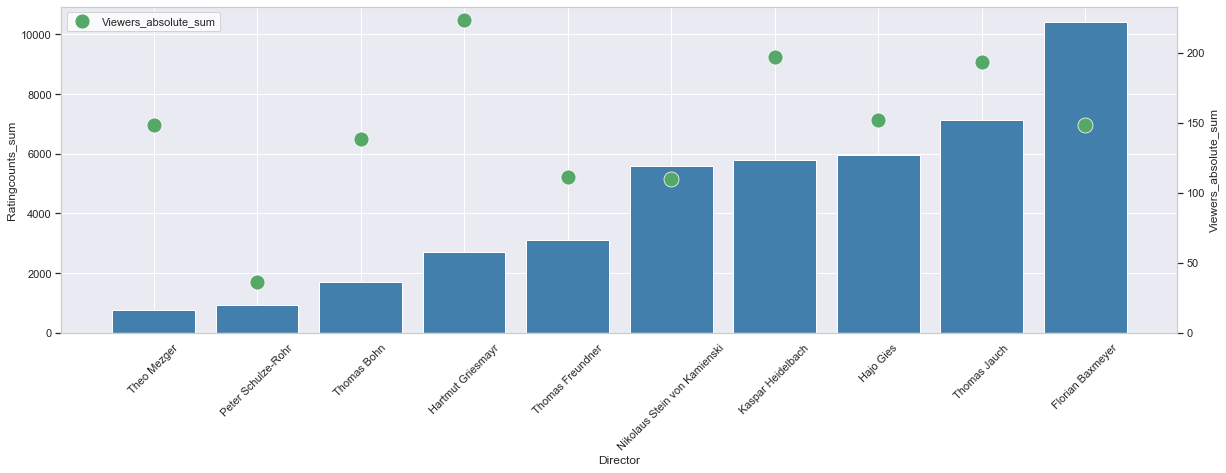

In [62]:
grouped = grouped.head(10)
sns.set(font_scale = 12)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 15})
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Director', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Director', y = 'Viewers_absolute_sum', marker="o",  label='Viewers_absolute_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Episodes from Hartmut Grießmayr received most viewers. Most voted were episodes from Florian Baxmeyer. Best average voting went to Nikolaus Stein von Kamienski.

## Script

In [63]:
grouped = Tatort_list.groupby('Script').mean()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped_script_sum = Tatort_list.groupby('Script').sum().reset_index()
grouped_script_sum_ratings = Tatort_list.groupby('Script').sum().reset_index()
grouped_script = Tatort_list.groupby('Script').count().reset_index()
grouped = pd.merge(grouped, grouped_script[['Script','Number_Episode']], left_on='Script', right_on='Script')
grouped = pd.merge(grouped, grouped_script_sum[['Script','Viewers_absolute']], left_on='Script', right_on='Script')
grouped = pd.merge(grouped, grouped_script_sum_ratings[['Script','Ratingcounts']], left_on='Script', right_on='Script')
grouped.rename( columns={'Number_Episode_y':'Amount_of_Episodes'}, inplace=True )
grouped.rename( columns={'Number_Episode_x':'Number_Episode'}, inplace=True )
grouped.rename( columns={'Ratingcounts_x':'Ratingcounts'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Amount_of_Episodes', ascending=False).reset_index(drop="True")
grouped.head(10)

,Script,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute_mean,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Amount_of_Episodes,Viewers_absolute_sum,Ratingcounts_sum
0,Jürgen Werner,886.400000,3.400000,417.400000,15.250000,174.550000,1162.850000,1.000000,1.0,1.050000,8.796000,24.760000,550.300000,348.450000,25.333333,19.352941,34.000000,20,175.92,8348.0
1,Felix Huby,410.700000,3.115000,108.400000,11.600000,218.300000,1481.800000,1.000000,1.0,1.000000,8.487000,25.185000,617.900000,489.823529,38.550000,22.461538,31.150000,20,169.74,2168.0
2,Herbert Lichtenfeld,72.894737,3.278947,225.263158,14.000000,175.315789,1185.421053,1.000000,1.0,1.000000,18.712000,57.789474,68.263158,NaN,6.000000,NaN,32.789474,19,93.56,4280.0
3,Fritz Eckhardt,99.058824,2.700000,41.470588,16.588235,99.882353,670.000000,1.000000,1.0,1.176471,17.620000,55.000000,87.687500,NaN,8.625000,NaN,27.000000,17,105.72,705.0
4,Thomas Bohn,607.000000,3.143750,93.500000,9.000000,165.687500,1151.125000,1.000000,1.0,1.000000,8.128667,23.206667,664.266667,462.266667,42.333333,24.230769,31.437500,16,121.93,1496.0
5,Andreas Pflüger,577.375000,2.981250,122.375000,12.187500,180.875000,1239.937500,1.000000,1.0,1.000000,7.575000,21.381250,813.187500,611.187500,42.062500,27.125000,29.812500,16,121.20,1958.0
6,Dorothee Schön,635.714286,3.321429,292.071429,10.785714,166.785714,1111.857143,1.000000,1.0,1.000000,8.242143,23.778571,667.142857,466.000000,22.714286,15.500000,33.214286,14,115.39,4089.0
7,Norbert Ehry,472.769231,3.215385,226.461538,10.769231,156.230769,1050.153846,1.000000,1.0,1.000000,9.812727,30.600000,449.750000,349.444444,34.833333,10.888889,32.153846,13,107.94,2944.0
8,Christian Jeltsch,781.923077,3.338462,476.384615,13.692308,199.153846,1319.615385,1.076923,1.0,1.076923,8.236923,23.438462,658.769231,457.076923,34.461538,17.454545,33.384615,13,107.08,6193.0
9,Harald Göckeritz,607.076923,2.946154,193.615385,10.307692,199.076923,1332.230769,1.000000,1.0,1.000000,8.143077,23.700000,626.153846,424.230769,39.000000,22.090909,29.461538,13,105.86,2517.0


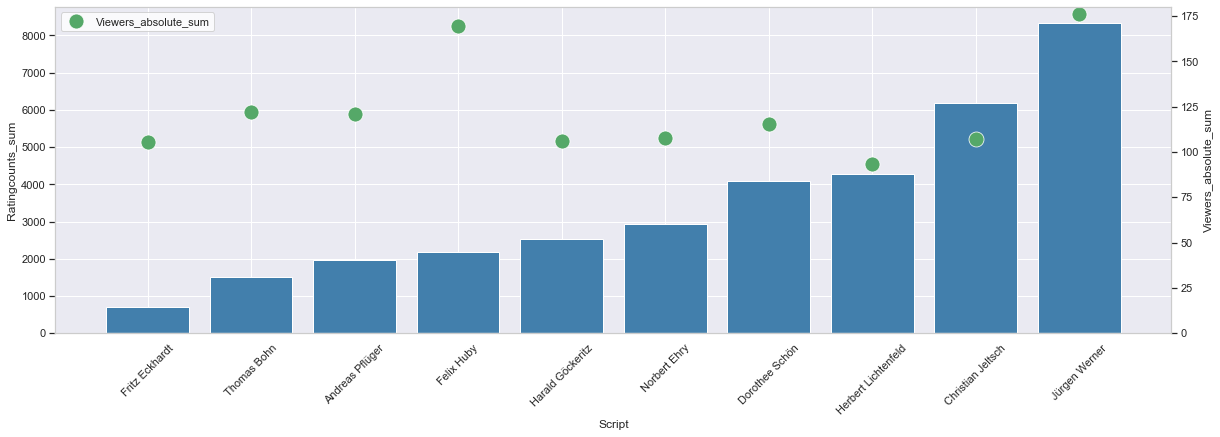

In [64]:
grouped = grouped.head(10)
sns.set(font_scale = 12)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 15})
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Script', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Script', y = 'Viewers_absolute_sum', marker="o",  label='Viewers_absolute_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Episodes from Jürgen Werners script received most viewers. Most voted were episodes scripted by Jürgen Werner as well, also best average voting.

## Camera

In [65]:
grouped = Tatort_list.groupby('Camera').mean()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped_camera_sum = Tatort_list.groupby('Camera').sum().reset_index()
grouped_camera_sum_ratings = Tatort_list.groupby('Camera').sum().reset_index()
grouped_camera = Tatort_list.groupby('Camera').count().reset_index()
grouped = pd.merge(grouped, grouped_camera[['Camera','Number_Episode']], left_on='Camera', right_on='Camera')
grouped = pd.merge(grouped, grouped_camera_sum[['Camera','Viewers_absolute']], left_on='Camera', right_on='Camera')
grouped = pd.merge(grouped, grouped_camera_sum_ratings[['Camera','Ratingcounts']], left_on='Camera', right_on='Camera')
grouped.rename( columns={'Number_Episode_y':'Amount_of_Episodes'}, inplace=True )
grouped.rename( columns={'Number_Episode_x':'Number_Episode'}, inplace=True )
grouped.rename( columns={'Ratingcounts_x':'Ratingcounts'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Amount_of_Episodes', ascending=False).reset_index(drop="True")
grouped.head(10)

,Camera,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute_mean,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Amount_of_Episodes,Viewers_absolute_sum,Ratingcounts_sum
0,Jürgen Carle,754.866667,3.246667,226.000000,11.866667,186.400000,1245.300000,1.0,1.200000,1.0,8.392333,23.453333,643.066667,441.166667,29.333333,14.148148,32.466667,30,251.77,6780.0
1,Hans-Jörg Allgeier,478.583333,3.083333,112.208333,8.708333,190.750000,1302.375000,1.0,1.125000,1.0,8.052500,23.145833,675.500000,473.583333,37.125000,24.260870,30.833333,24,193.26,2693.0
2,Wolf Siegelmann,710.210526,3.047368,335.894737,13.157895,170.421053,1156.842105,1.0,1.473684,1.0,8.517895,24.689474,608.578947,408.421053,31.263158,16.444444,30.473684,19,161.84,6382.0
3,Werner Hoffmann,221.888889,2.933333,138.777778,9.388889,189.833333,1253.333333,1.0,1.166667,1.0,13.256250,40.394444,324.555556,395.125000,24.333333,20.333333,29.333333,18,212.10,2498.0
4,Armin Alker,662.833333,3.233333,685.666667,11.555556,170.333333,1127.611111,1.0,1.111111,1.0,8.249444,23.955556,609.222222,407.222222,39.555556,19.937500,32.333333,18,148.49,12342.0
5,Wolfgang Koch,229.764706,2.964706,46.411765,11.588235,114.588235,771.352941,1.0,1.117647,1.0,12.467500,36.952941,381.117647,463.500000,26.000000,20.714286,29.647059,17,199.48,789.0
6,Clemens Messow,763.733333,3.360000,267.733333,13.800000,165.066667,1114.333333,1.0,1.466667,1.0,8.827333,24.680000,602.200000,401.533333,40.500000,21.666667,33.600000,15,132.41,4016.0
7,Arthur W. Ahrweiler,527.928571,3.314286,396.285714,11.571429,198.285714,1349.714286,1.0,1.142857,1.0,7.647857,22.971429,692.000000,490.500000,49.357143,25.285714,33.142857,14,107.07,5548.0
8,Ralf Noack,753.307692,3.276923,302.000000,14.615385,171.692308,1153.538462,1.0,1.076923,1.0,8.303846,22.823077,690.153846,488.153846,30.461538,13.615385,32.769231,13,107.95,3926.0
9,Immo Rentz,389.923077,2.938462,81.538462,8.230769,165.846154,1108.461538,1.0,1.153846,1.0,10.540000,29.484615,566.923077,504.700000,25.153846,27.750000,29.384615,13,137.02,1060.0


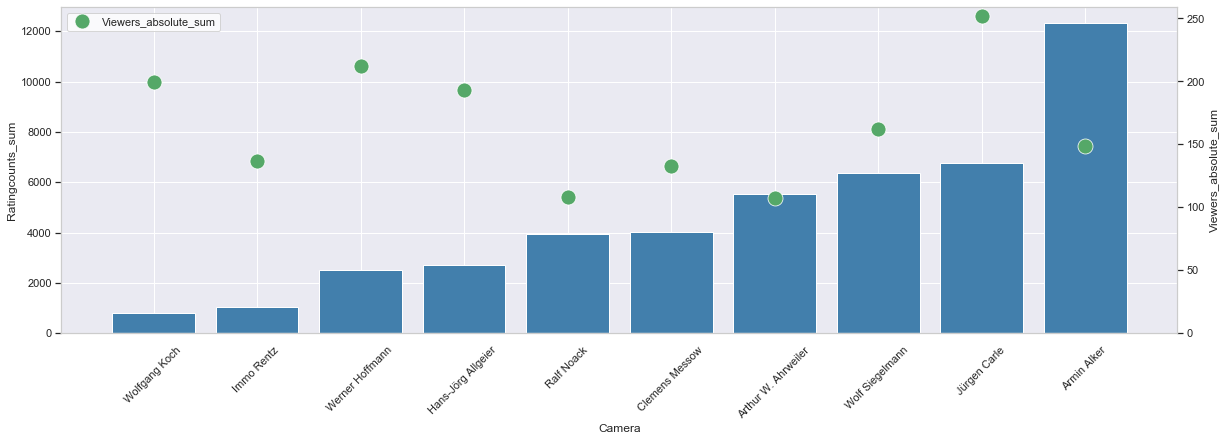

In [66]:
grouped = grouped.head(10)
sns.set(font_scale = 12)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 15})
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'Camera', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'Camera', y = 'Viewers_absolute_sum', marker="o",  label='Viewers_absolute_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Episodes filmed by Jürgen Carle received most viewers. Most voted were episodes from Armin Alter. Best average voting went to Clemens Messow.

## TV Stations

In [67]:
grouped = Tatort_list.groupby('TV_stations').mean()
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_mean'}, inplace=True )
grouped_TV_stations_sum = Tatort_list.groupby('TV_stations').sum().reset_index()
grouped_TV_stations_sum_ratings = Tatort_list.groupby('TV_stations').sum().reset_index()
grouped_TV_stations = Tatort_list.groupby('TV_stations').count().reset_index()
grouped = pd.merge(grouped, grouped_TV_stations[['TV_stations','Number_Episode']], left_on='TV_stations', right_on='TV_stations')
grouped = pd.merge(grouped, grouped_TV_stations_sum[['TV_stations','Viewers_absolute']], left_on='TV_stations', right_on='TV_stations')
grouped = pd.merge(grouped, grouped_TV_stations_sum_ratings[['TV_stations','Ratingcounts']], left_on='TV_stations', right_on='TV_stations')
grouped.rename( columns={'Number_Episode_y':'Amount_of_Episodes'}, inplace=True )
grouped.rename( columns={'Number_Episode_x':'Number_Episode'}, inplace=True )
grouped.rename( columns={'Ratingcounts_x':'Ratingcounts'}, inplace=True )
grouped.rename( columns={'Ratingcounts_y':'Ratingcounts_sum'}, inplace=True )
grouped.rename( columns={'Viewers_absolute':'Viewers_absolute_sum'}, inplace=True )
grouped = grouped.sort_values('Amount_of_Episodes', ascending=False).reset_index(drop="True")
grouped.head(10)

,TV_stations,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute_mean,Viewers_%,Ranking,Ranking_after_1990,Ranking_city,Ranking_city_after_1990,Ratings_simple,Amount_of_Episodes,Viewers_absolute_sum,Ratingcounts_sum
0,WDR,536.439791,3.329319,289.602094,12.057592,168.795812,1144.078534,1.000000,1.413613,1.015707,10.265256,32.637989,399.229050,291.875000,24.921788,19.822034,33.293194,191,1601.38,55314.0
1,NDR,530.853801,3.225146,266.280702,11.228070,170.152047,1153.923977,1.000000,1.245614,1.005848,9.705448,31.255152,478.157576,390.960630,26.310976,15.714286,32.251462,171,1407.29,45534.0
2,SWR,730.461538,3.171538,202.246154,11.707692,193.138462,1296.884615,1.000000,1.246154,1.030769,8.168295,23.359690,651.077519,449.155039,31.333333,18.913793,31.715385,130,1053.71,26292.0
3,BR,524.741071,3.203571,188.607143,13.696429,192.000000,1306.955357,1.000000,1.294643,1.000000,9.337604,30.217273,496.818182,402.674419,50.363636,27.962963,32.035714,112,896.41,21124.0
4,ORF,477.136364,3.022727,120.568182,12.943182,147.352273,1004.397727,1.000000,1.125000,1.056818,8.846393,30.295714,560.442857,506.811321,35.185714,17.102041,30.227273,88,539.63,10610.0
5,HR,526.197674,3.118605,436.325581,11.674419,177.441860,1173.732558,1.000000,1.209302,1.011628,9.580933,30.850602,550.132530,488.484375,34.457831,20.965517,31.186047,86,718.57,37524.0
6,MDR,658.691358,3.060494,154.827160,12.333333,197.777778,1337.555556,1.000000,1.333333,1.000000,8.074500,23.733750,637.900000,436.250000,16.887500,12.179104,30.604938,81,645.96,12541.0
7,SFB,300.185185,2.733333,86.666667,10.037037,150.592593,1033.351852,1.000000,1.351852,1.000000,9.397317,31.056250,543.083333,551.750000,38.083333,24.322581,27.333333,54,385.29,4680.0
8,SR,548.820513,2.876923,199.923077,12.461538,159.307692,1089.282051,1.000000,1.564103,1.000000,8.613030,27.452778,650.750000,559.366667,18.805556,10.160000,28.769231,39,284.23,7797.0
9,RB,702.944444,3.327778,434.694444,14.805556,143.111111,954.388889,1.083333,1.472222,1.000000,8.086000,24.230556,640.388889,454.085714,22.500000,14.625000,33.277778,36,283.01,15649.0


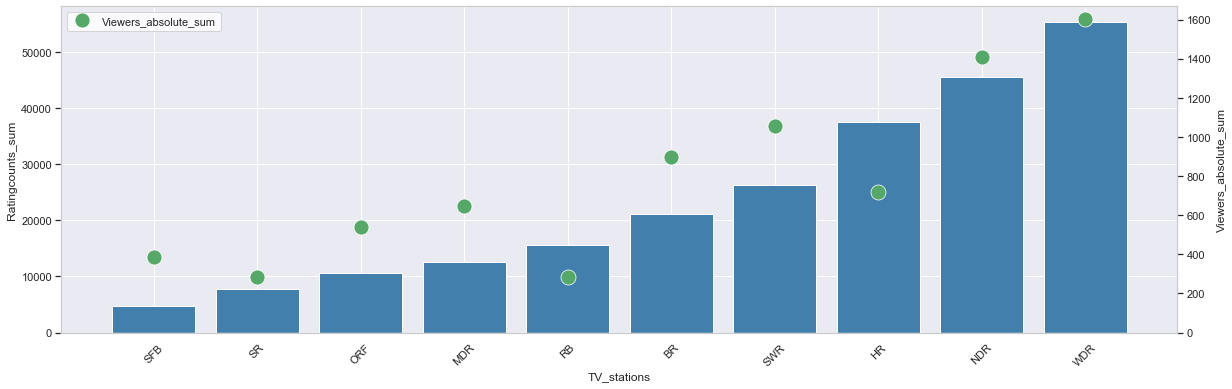

In [68]:
grouped = grouped.head(10)
sns.set(font_scale = 12)
sns.set_context("talk")
sns.set(rc={"lines.linewidth": 0, 'lines.markersize': 15})
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
sns.set_style("whitegrid", {'axes.grid' : False})
grouped = grouped.sort_values('Ratingcounts_sum')
ax= sns.barplot(x = 'TV_stations', y = 'Ratingcounts_sum',  label='Ratingcounts_sum', data=grouped, color = "#3182bd", ci=None)
ax2 = ax.twinx()
sns.lineplot(x = 'TV_stations', y = 'Viewers_absolute_sum', marker="o",  label='Viewers_absolute_sum', data=grouped, sort=False, color = "g",  ci=None)
ax.set(ylim=(0))
ax2.set(ylim=(0))
plt.legend(loc='upper left')
ax.xaxis.grid(True)
plt.show()

Most episodes were produced by the WDR (also highest amount of viewers and average rating) followed by NDR. 

# Recommendation System

Here we will try to create a recommender system based on our data. There are two types of systems:
    
    -Content-based
    -Collaborative Filtering
    
We will use the first one since we do not have the indicidual ratings of the users and therefore cannot determine the similarity between the individual ratings.

We start by defining some variables:

## By Rating

In [6]:
V = Tatort_list['Ratingcounts']
R = Tatort_list['Ratings']
C = Tatort_list['Ratings'].mean()
m = Tatort_list['Ratingcounts'].quantile(0.70)

Tatort_list['Weighted_average'] = (V/(V+m) * R) + (m/(m+V) * C)
#Creation of weighted Average

In [7]:
Tatort_ranked = Tatort_list.sort_values('Weighted_average', ascending=False)
Tatort_ranked[['Title', 'Place','Ratingcounts', 'Ratings', 'Weighted_average']].head(20)

,Title,Place,Ratingcounts,Ratings,Weighted_average
182,Im Schmerz geboren,Wiesbaden,3470.0,4.0,3.953180
351,Weil sie böse sind,Frankfurt,2556.0,3.8,3.752334
169,Borowski und der Himmel über Kiel,Kiel,2050.0,3.8,3.741626
1042,Reifezeugnis,Kiel,1810.0,3.8,3.734663
163,Die Wiederkehr,Bremen,2149.0,3.7,3.652687
318,Nie wieder frei sein,München,1844.0,3.7,3.645635
207,Franziska,Köln,1753.0,3.7,3.643105
540,Abschaum,Bremen,1689.0,3.7,3.641180
165,Das Haus am Ende der Straße,Frankfurt,1591.0,3.7,3.637965
550,Das Böse,Frankfurt,1520.0,3.7,3.635408


By weighted average rating, we see that the episodes are different but we find Reifezeugniss and Im Schmerz geboren here.

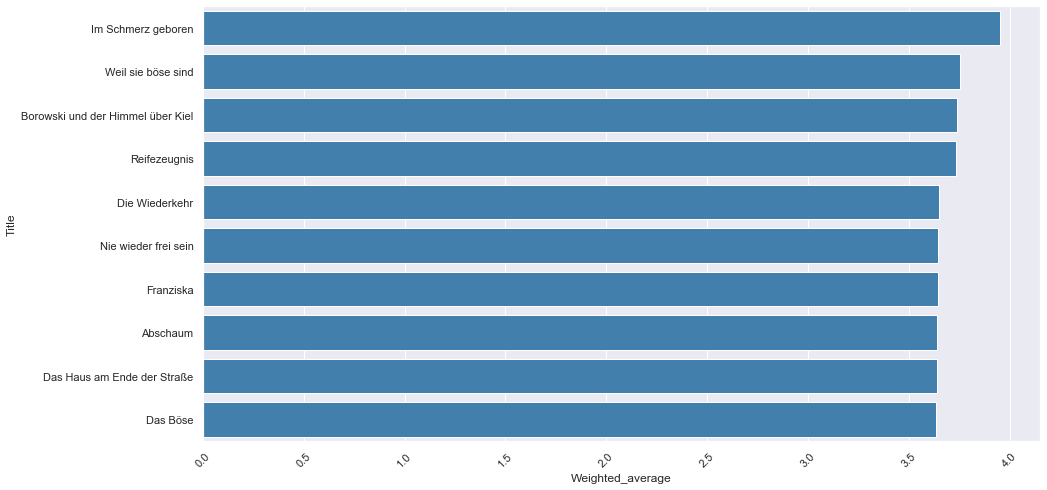

In [94]:
wavg = Tatort_ranked.sort_values('Weighted_average', ascending=False)
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
sns.barplot(x=wavg['Weighted_average'].head(10),  y=wavg['Title'].head(10), color = "#3182bd",  label='Amount_of_Episodes', data=wavg)
plt.xticks(rotation=45)
plt.show()

The algorithm would recommend us the above mentioned movies. "Im Schmerz geboren" from Wiesbaden is the first with 4 out of 5 weighted average scoring.

## By popularity (amount of viewers)

In [95]:
Tatort_popular = Tatort_list.sort_values('Viewers_absolute', ascending=False)
Tatort_popular[['Title', 'Place','Viewers_absolute', 'Ratings']].head(20)

,Title,Place,Viewers_absolute,Ratings
1032,Rot – rot – tot,Stuttgart,26.57,3.3
1042,Reifezeugnis,Kiel,25.05,3.8
1030,Zürcher Früchte,Frankfurt,24.91,3.0
939,Tod macht erfinderisch,Berlin,23.58,2.6
931,Der Tausch,Duisburg,23.46,3.3
997,Schönes Wochenende,Essen,22.28,3.2
985,Im Fadenkreuz,München,22.22,3.3
961,Freiwild,Berlin,20.90,2.8
934,Einer sah den Mörder,Stuttgart,20.70,3.2
993,Beweisaufnahme,Berlin,20.65,3.1


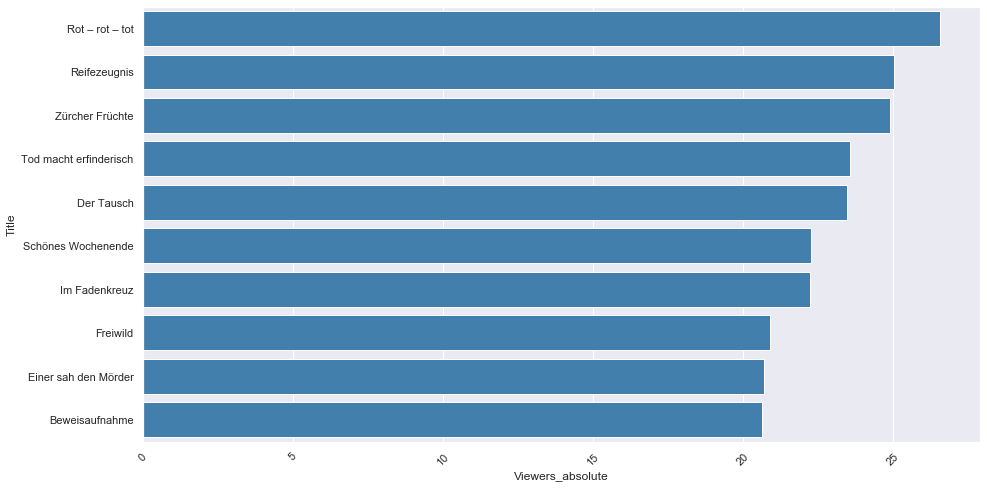

In [96]:
popular = Tatort_popular.sort_values('Viewers_absolute', ascending=False)
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
sns.barplot(x=popular['Viewers_absolute'].head(10),  y=popular['Title'].head(10), color = "#3182bd",  label='Viewers_absolute', data=popular)
plt.xticks(rotation=45)
plt.show()

The most popular recommender would recommend other episodes here, for example "Rot-rot-tot" from Stuttgart. 

What if we want to recommend episodes based on their weighted average ratings and their popularity?

## By weighted average ratings and popularity

First, we need to normalize the values by applying a 50/50 split between the scaled weighted average rating and popularity scores.

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
Tatort_scaled = min_max_scaler.fit_transform(Tatort_list[['Weighted_average', 'Viewers_absolute']])
Tatort_norm  = pd.DataFrame(Tatort_scaled, columns=['Weighted_average', 'Viewers_absolute'])
Tatort_norm.head()

,Weighted_average,Viewers_absolute
0,0.564198,NaN
1,0.626559,NaN
2,0.628454,NaN
3,0.588545,0.231343
4,0.592865,0.321288


In [9]:
Tatort_list[['norm_weighted_average', 'norm_popularity']] = Tatort_norm

In [10]:
Tatort_list['score'] = Tatort_list['norm_weighted_average'] * 0.5 + Tatort_list['norm_popularity'] * 0.5
Tatort_scored = Tatort_list.sort_values(['score'], ascending=False)
Tatort_scored[['Title', 'Place', 'norm_weighted_average', 'norm_popularity', 'score']].head(20)

,Title,Place,norm_weighted_average,norm_popularity,score
1042,Reifezeugnis,Kiel,0.885698,0.940299,0.912998
1032,Rot – rot – tot,Stuttgart,0.615726,1.000000,0.807863
931,Der Tausch,Duisburg,0.624748,0.877848,0.751298
1030,Zürcher Früchte,Frankfurt,0.549937,0.934800,0.742368
985,Im Fadenkreuz,München,0.608182,0.829144,0.718663
939,Tod macht erfinderisch,Berlin,0.538519,0.882561,0.710540
997,Schönes Wochenende,Essen,0.587959,0.831500,0.709729
967,Peggy hat Angst,Baden-Baden,0.735407,0.657895,0.696651
934,Einer sah den Mörder,Stuttgart,0.584230,0.769442,0.676836
993,Beweisaufnahme,Berlin,0.574320,0.767478,0.670899


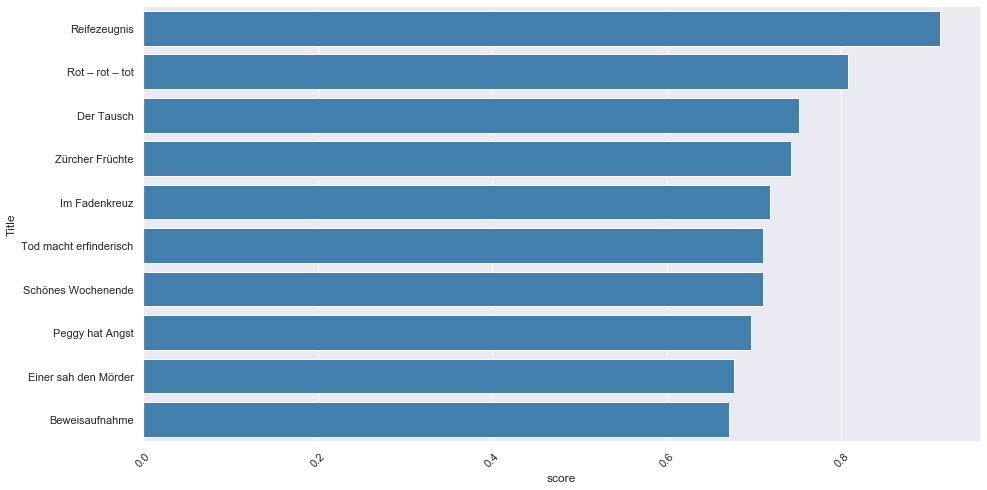

In [11]:
popular = Tatort_scored.sort_values('score', ascending=False)
sns.set(font_scale = 1)
plt.figure(figsize=(15,8))
sns.barplot(x=popular['score'].head(10),  y=popular['Title'].head(10), color = "#3182bd",  label='Viewers_absolute', data=Tatort_scored)
plt.xticks(rotation=45)
plt.show()

Interesting, here we see different Tatort episodes, lets have one closer look...

In [12]:
Tatort_scored[['Title', 'Place', 'norm_weighted_average', 'norm_popularity', 'score','Year']].head(20)

,Title,Place,norm_weighted_average,norm_popularity,score,Year
1042,Reifezeugnis,Kiel,0.885698,0.940299,0.912998,1977
1032,Rot – rot – tot,Stuttgart,0.615726,1.000000,0.807863,1978
931,Der Tausch,Duisburg,0.624748,0.877848,0.751298,1986
1030,Zürcher Früchte,Frankfurt,0.549937,0.934800,0.742368,1978
985,Im Fadenkreuz,München,0.608182,0.829144,0.718663,1981
939,Tod macht erfinderisch,Berlin,0.538519,0.882561,0.710540,1985
997,Schönes Wochenende,Essen,0.587959,0.831500,0.709729,1980
967,Peggy hat Angst,Baden-Baden,0.735407,0.657895,0.696651,1983
934,Einer sah den Mörder,Stuttgart,0.584230,0.769442,0.676836,1986
993,Beweisaufnahme,Berlin,0.574320,0.767478,0.670899,1981


Interestingly, of the top 20 episodes only 2 have been produced after 2000, none of them in the 90s, 15 in the 80s and 3 in the 70s (the top 2). But this is not really content-based. Lets try it with content.

## By content

In [13]:
stop_ger = stopwords.words('german')

In [103]:
stop_ger_and_en = text.ENGLISH_STOP_WORDS.union(stop_ger)
stop_ger_and_en = text.ENGLISH_STOP_WORDS.union(["fur","konnen","konnte","uber","wahrend","wurde","wurden"])

In [104]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = stop_ger)

# Filling NaNs with empty string
Tatort_list['Story'] = Tatort_list['Story'].fillna('')

# Fitting the TF-IDF on the 'overview' text
tfv_matrix = tfv.fit_transform(Tatort_list['Story'])

tfv_matrix.shape

(1110, 7932)

1,110 episodes and 7,928 unique words

What we did here: We put the story text of the episodes into a matrix which is being matched across the episodes. We can therefore compare the episodes by their teaser text.

In [108]:
# Compute the sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

# Reverse mapping of indices and movie titles
indices = pd.Series(Tatort_list.index, index=Tatort_list['Title']).drop_duplicates()

# Credit to Ibtesam Ahmed for the skeleton code
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwsie similarity scores 
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies 
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    episode_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return Tatort_list['Title'].iloc[episode_indices]

We defined a variable to get our recommendation system running...

In [109]:
give_rec('Nemesis')

10                 Das Nest
43     Wer jetzt allein ist
67             Auge um Auge
57                  Déjà-vu
124        Auf einen Schlag
107     Der König der Gosse
78                  Level X
335          Operation Hiob
250            Todesschütze
175          Weihnachtsgeld
Name: Title, dtype: object

Ok, so we did the following here: 
    
    -A matrix has been created with the most common words from the story
    -The recommender will therefore pick the most related movie by the story
    -Limitation here is the German language, machine learning does not work too well with German texts
    -A first test with the epsiode "Nemesis" was succesful however.
        -In Nemesis, the story plays in Dresden and the next episode is very close to that episode
        -Both episodes play in Dresden
        -Nemesis is an episode with the new detective. The first recommendation is also with the new detective and plays in Dresden. 
        -The plot is not similar, improvement is necessary here....
        -An improvement could be to translate the text first and then apply TF-IDF
        -Also, a cluster analysis could help to find the most common topics

# Predicition - Rating prediction

The aim is to predict the ratings, lets give it a try.

## Data preperation

This part will deal with making the data ready for ML.

In [4]:
Tatort_list.dtypes

Number_Episode                      int64
Dates                      datetime64[ns]
Detectives                         object
Title                              object
Place                              object
Links                              object
Ratings                           float64
Ratingcounts                      float64
TV_stations                        object
Amount_actors                       int64
Story                              object
Director                           object
Script                             object
Camera                             object
Story_words_amount                  int64
Story_len                           int64
Amount_Director                     int64
Amount_Script                       int64
Amount_Camera                       int64
Viewers_absolute                  float64
Viewers_%                         float64
Ranking                           float64
Ranking_after_1990                float64
Ranking_city                      

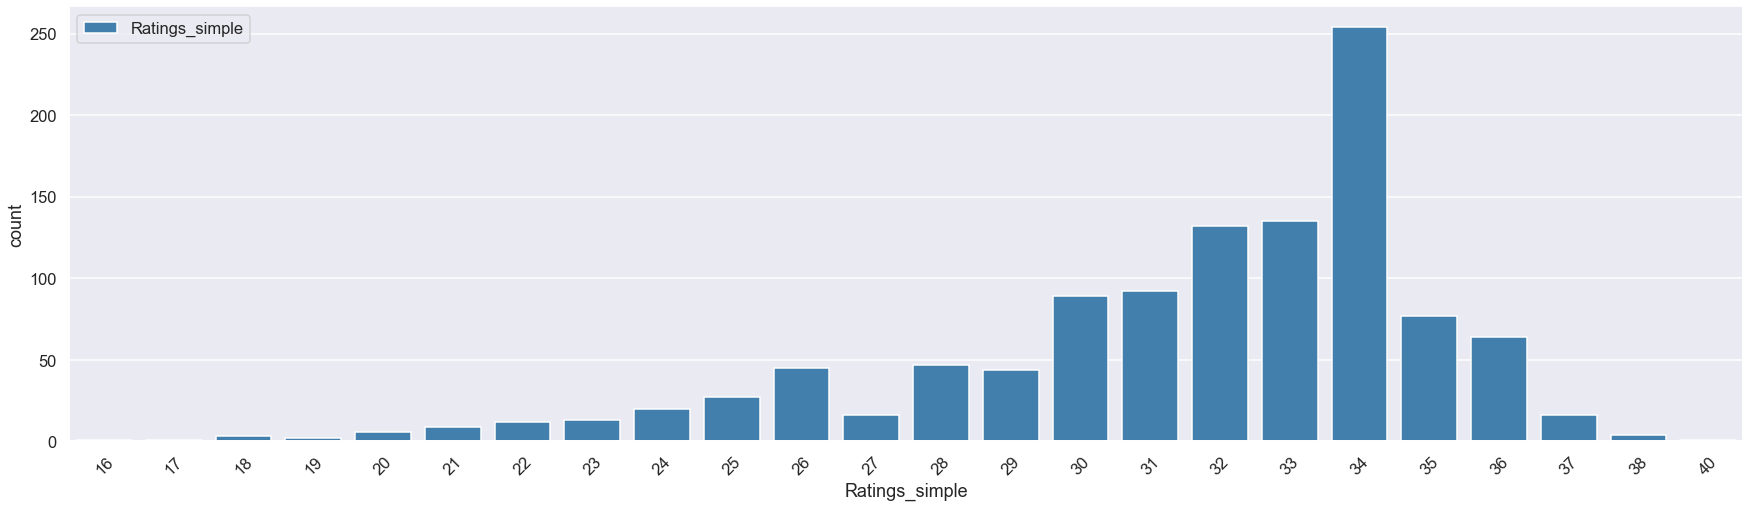

In [5]:
sns.set(font_scale = 1)
sns.set_context("talk")
plt.figure(figsize=(30,8))
sns.countplot('Ratings_simple', color = "#3182bd", label='Ratings_simple', data=Tatort_list)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [6]:
#Transform method taking points as param
def transform_Ratings_simple(points):
    if points < 21:
        return 1
    elif points >= 21 and points < 26:
        return 2 
    elif points >= 26 and points < 31:
        return 3 
    elif points >= 31 and points < 36:
        return 4 
    else:
        return 5

#Applying transform method and assigning result to new column "points_simplified"
Tatort_list = Tatort_list.assign(Ratings_simple_class = Tatort_list['Ratings_simple'].apply(transform_Ratings_simple))
Tatort_list[['Ratings_simple_class','Ratings_simple','Ratings']]

,Ratings_simple_class,Ratings_simple,Ratings
0,3,28,2.8
1,5,36,3.6
2,4,35,3.5
3,4,33,3.3
4,4,33,3.3
...,...,...,...
1105,4,33,3.3
1106,4,33,3.3
1107,4,34,3.4
1108,4,33,3.3


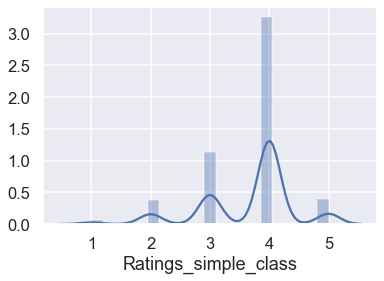

In [7]:
ax = sns.distplot(Tatort_list['Ratings_simple_class'])
sns.set(rc={'figure.figsize':(10,10)})

In [8]:
Tatort_list_ml = Tatort_list

Tatort_list_ml['dayofweek'] = Tatort_list_ml['Dates'].dt.dayofweek
Tatort_list_ml['quarter'] = Tatort_list_ml['Dates'].dt.quarter
Tatort_list_ml['month'] = Tatort_list_ml['Dates'].dt.month
Tatort_list_ml['year'] = Tatort_list_ml['Dates'].dt.year
Tatort_list_ml['dayofyear'] = Tatort_list_ml['Dates'].dt.dayofyear
Tatort_list_ml['dayofmonth'] = Tatort_list_ml['Dates'].dt.day
Tatort_list_ml['weekofyear'] = Tatort_list_ml['Dates'].dt.weekofyear
    
Tatort_list_ml['dayofweek'] = Tatort_list_ml['dayofweek'].astype('int64')
Tatort_list_ml['quarter'] = Tatort_list_ml['quarter'].astype('int64')
Tatort_list_ml['month'] = Tatort_list_ml['month'].astype('int64')
Tatort_list_ml['year'] = Tatort_list_ml['year'].astype('int64')
Tatort_list_ml['dayofyear'] = Tatort_list_ml['dayofyear'].astype('int64')
Tatort_list_ml['dayofmonth'] = Tatort_list_ml['dayofmonth'].astype('int64')
Tatort_list_ml['weekofyear'] = Tatort_list_ml['weekofyear'].astype('int64')

Tatort_list_ml.drop(columns =["Story"], inplace = True) 
Tatort_list_ml.drop(columns =["Links"], inplace = True) 
Tatort_list_ml.drop(columns =["Dates"], inplace = True) 
Tatort_list_ml.drop(columns =["Title"], inplace = True) 
Tatort_list_ml.drop(columns =["Day"], inplace = True) 
Tatort_list_ml.drop(columns =["Month"], inplace = True) 
Tatort_list_ml.drop(columns =["Year"], inplace = True) 

Tatort_list_ml['Ratings_simple_class_lag_1'] = Tatort_list_ml['Ratings_simple_class'].shift(-1)
Tatort_list_ml['Ratings_simple_lag_1'] = Tatort_list_ml['Ratings_simple'].shift(-1)
Tatort_list_ml['Ratings_lag_1'] = Tatort_list_ml['Ratings'].shift(-1)

Tatort_list_ml

,Number_Episode,Detectives,Place,Ratings,Ratingcounts,TV_stations,Amount_actors,Director,Script,Camera,...,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Ratings_simple_class_lag_1,Ratings_simple_lag_1,Ratings_lag_1
0,1102,Odenthal/Stern,Ludwigshafen,2.8,19.0,SWR,13,Thomas Bohn,Thomas Bohn,Cornelia Janssen,...,4,3,8,2019,221,9,32,5.0,36.0,3.6
1,1101,Brix/Janneke,Frankfurt,3.6,50.0,HR,10,Emily Atef,"Emily Atef, Lars Hubrich",Armin Dierolf,...,2,1,1,2019,9,9,2,4.0,35.0,3.5
2,1100,Gorniak/Winkler,Dresden,3.5,73.0,MDR,12,Stephan Wagner,"Mark Monheim, Stephan Wagner",Hendrik A. Kley,...,6,3,8,2019,230,18,33,4.0,33.0,3.3
3,1099,Flückiger/Ritschard,Luzern,3.3,25.0,SRF,8,Katalin Gödrös,"Urs Bühler, Michael Herzig",Jutta Pohlmann,...,6,2,6,2019,167,16,24,4.0,33.0,3.3
4,1098,Ballauf/Schenk,Köln,3.3,40.0,WDR,16,Christine Hartmann,"Rainer Butt, Christine Hartmann",Peter Nix,...,6,4,10,2019,279,6,40,4.0,34.0,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,10,Trimmel,Hamburg,3.3,81.0,NDR,20,Peter Schulze-Rohr,Friedhelm Werremeier,Nils-Peter Mahlau,...,3,4,12,1971,343,9,49,4.0,33.0,3.3
1106,9,Trimmel,Hamburg,3.3,91.0,NDR,11,Peter Schulze-Rohr,Friedhelm Werremeier,Nils-Peter Mahlau,...,6,4,11,1971,311,7,44,4.0,34.0,3.4
1107,8,Finke,Kiel,3.4,472.0,NDR,19,Wolfgang Petersen,Herbert Lichtenfeld,Jörg-Michael Baldenius,...,6,2,6,1971,164,13,23,4.0,33.0,3.3
1108,7,Kressin,Köln,3.3,212.0,WDR,19,Rolf von Sydow,Wolfgang Menge,Franz Rath,...,4,1,2,1971,36,5,5,4.0,31.0,3.1


We have done two things here:
    1. After having a look on the ratings, I created some simplyer rating classes
    2. Then we created some columns based on the data, such as the date or the rating from the last episode

In [9]:
list(Tatort_list_ml.columns.values)                   

['Number_Episode',
 'Detectives',
 'Place',
 'Ratings',
 'Ratingcounts',
 'TV_stations',
 'Amount_actors',
 'Director',
 'Script',
 'Camera',
 'Story_words_amount',
 'Story_len',
 'Amount_Director',
 'Amount_Script',
 'Amount_Camera',
 'Viewers_absolute',
 'Viewers_%',
 'Ranking',
 'Ranking_after_1990',
 'Ranking_city',
 'Ranking_city_after_1990',
 'Actors',
 'Ratings_simple',
 'Ratings_simple_class',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'Ratings_simple_class_lag_1',
 'Ratings_simple_lag_1',
 'Ratings_lag_1']

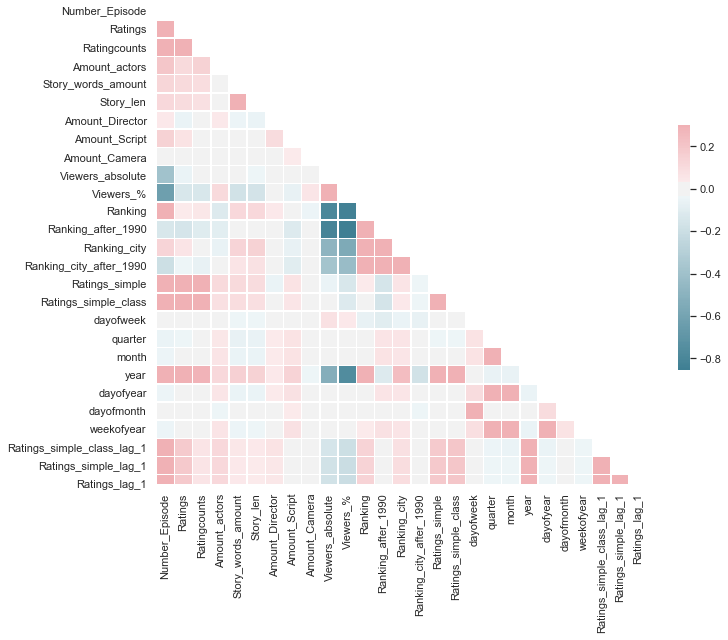

In [10]:
sns.set(font_scale = 0.5)
sns.set(style="white")

# Compute the correlation matrix
corr = Tatort_list_ml.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

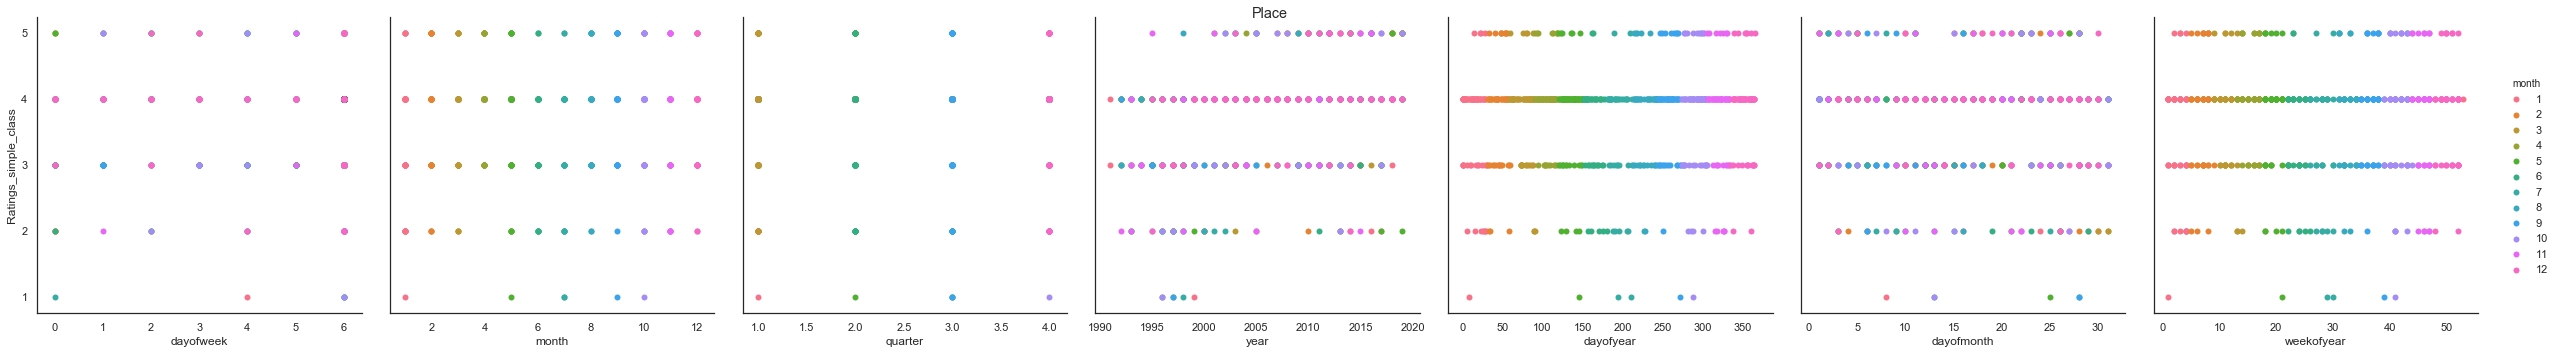

In [11]:
sns.pairplot(Tatort_list_ml.dropna(),
             hue='month',
             x_vars=['dayofweek','month','quarter','year','dayofyear','dayofmonth','weekofyear'],
             y_vars='Ratings_simple_class',
             height=5,
             plot_kws={'alpha':1, 'linewidth':0}
            )
plt.suptitle('Place')
plt.show()

In [12]:
Tatort_list_ml = pd.get_dummies(Tatort_list_ml, columns=['Detectives','TV_stations','Place','Director','Script','Camera'])
Tatort_list_ml_Actors_dummys = pd.DataFrame(Tatort_list.Actors.values.tolist()).stack().str.get_dummies().sum(level=0) 
Tatort_list_ml = pd.merge(Tatort_list_ml, Tatort_list_ml_Actors_dummys, left_index=True, right_index=True)
Tatort_list_ml.drop(columns =["Actors"], inplace = True) 
Tatort_list_ml = Tatort_list_ml.fillna(0)
Tatort_list_ml

,Number_Episode,Ratings,Ratingcounts,Amount_actors,Story_words_amount,Story_len,Amount_Director,Amount_Script,Amount_Camera,Viewers_absolute,...,Zlatko Maltar,Zoe Moore,Zoe Weiland,Zora Müller,Zoran Pingel,Zvonimir Ankovic,Özay Fecht,Özgür Emre Yildirim,Özgür Karadeniz,Ünal Gümüs
0,1102,2.8,19.0,13,155,1168,1,1,1,0.00,...,0,0,0,0,0,0,0,0,0,0
1,1101,3.6,50.0,10,187,1305,1,2,1,0.00,...,0,0,0,0,0,0,0,0,0,0
2,1100,3.5,73.0,12,167,1131,1,2,1,0.00,...,0,0,0,0,0,0,0,0,0,0
3,1099,3.3,25.0,8,292,1940,1,2,1,7.00,...,0,0,0,0,0,0,0,0,0,0
4,1098,3.3,40.0,16,103,693,1,2,1,9.29,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,10,3.3,81.0,20,221,1507,1,1,1,0.00,...,0,0,0,0,0,0,0,0,0,0
1106,9,3.3,91.0,11,115,696,1,1,1,0.00,...,0,0,0,0,0,0,0,0,0,0
1107,8,3.4,472.0,19,190,1252,1,1,1,0.00,...,0,0,0,0,0,0,0,0,0,0
1108,7,3.3,212.0,19,114,779,1,1,1,0.00,...,0,0,0,0,0,0,0,0,0,0


This part puts the variables as dummies via One-Hot encoding. 

In [13]:
Tatort_list_ml.to_csv('Tatort_list_ml.CSV',sep=',')

## Feature Selection and train test split

Ready for ML!
First the definition of test and training sets and then the application of RandomForest and XGBoost

In [14]:
x = Tatort_list_ml[Tatort_list_ml.columns.difference(['Ratings_simple_class','Ratings','Ratings_simple','Weighted_average','norm_popularity','score','norm_weighted_average'])]  
y = Tatort_list_ml['Ratings_simple_class'] # Target variable

We have to remove everything related to rating from our previous work since in real world we do not have that available. 

In [15]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=101) # 70% training and 30% test

# Random Forest

In [16]:
forest = RandomForestClassifier(n_jobs=-1)  # use all cores
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [17]:
forest.score(X_test, y_test)

0.6756756756756757

In [18]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

In [19]:
# Make predictions using the testing set
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         5
           3       0.62      0.33      0.43        30
           4       0.70      0.94      0.80        69
           5       0.00      0.00      0.00         7

    accuracy                           0.68       111
   macro avg       0.33      0.32      0.31       111
weighted avg       0.60      0.68      0.62       111



In [20]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.35135135135135137
Mean Squared Error: 0.40540540540540543
Root Mean Squared Error: 0.6367145399670133


<Figure size 1440x720 with 0 Axes>

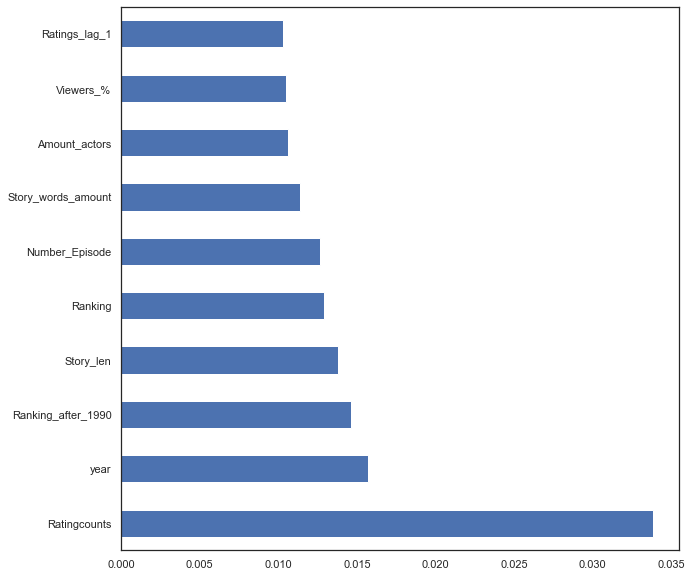

<Figure size 1440x720 with 0 Axes>

In [23]:
feat_importances = pd.Series(forest.feature_importances_, index=X_test.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.figure(figsize=(20,10))

In [22]:
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.66019417 0.66336634 0.64356436 0.66       0.66       0.65
 0.62626263 0.64646465 0.65306122 0.71428571]
Mean: 0.6577199079329372
Standard Deviation: 0.021554613590395684


First stop here!
    
    -We see that the random forest gave us an accuracy of 68%
    -The variables show that ratingcounts, year and the number of the episode are the most important
    -CV shows that the accuracy is at 66%
    
Can we get better?
Lets try hyperparameter tuning using randomized search first

In [71]:
rf = RandomForestClassifier(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [72]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [73]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 10.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [74]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [75]:
best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)
best_random.score(X_test, y_test)

0.6756756756756757

In [76]:
y_pred = best_random.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print(classification_report(y_test, y_pred))

Mean Absolute Error: 0.36036036036036034
Mean Squared Error: 0.43243243243243246
Root Mean Squared Error: 0.6575959492214292
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         5
           3       0.70      0.23      0.35        30
           4       0.67      0.97      0.79        69
           5       1.00      0.14      0.25         7

    accuracy                           0.68       111
   macro avg       0.59      0.34      0.35       111
weighted avg       0.67      0.68      0.60       111



In [77]:
rfc_cv = best_random
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.69902913 0.64356436 0.64356436 0.66       0.64       0.66
 0.6969697  0.63636364 0.64285714 0.73469388]
Mean: 0.6657042192826377
Standard Deviation: 0.03152243859556298


The result is a accuracy of 67%. We have not become better.

Lets try grid search:

In [78]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [79]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.8min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [80]:
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
best_grid.score(X_test, y_test)

0.6216216216216216

In [81]:
y_pred = best_grid.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print(classification_report(y_test, y_pred))

Mean Absolute Error: 0.42342342342342343
Mean Squared Error: 0.5135135135135135
Root Mean Squared Error: 0.7165985720844785
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        30
           4       0.62      1.00      0.77        69
           5       0.00      0.00      0.00         7

    accuracy                           0.62       111
   macro avg       0.16      0.25      0.19       111
weighted avg       0.39      0.62      0.48       111



In [82]:
rfc_cv = best_grid
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.61165049 0.61386139 0.61386139 0.62       0.62       0.62
 0.62626263 0.62626263 0.63265306 0.63265306]
Mean: 0.6217204632688353
Standard Deviation: 0.007170219712364973


62%, a good start but not very encouraging outcomes.

# XGBOOST

Lets try XGBoost

In [83]:
#converting our data into a dmatrix to take advantage of efficiency gains
data_dmatrix = xgb.DMatrix(data=x,label=y)

In [84]:
#calling the XGBRegressor classifier
xg_class = XGBClassifier(n_estimators=100)

In [85]:
#fitting and predicting
xg_class.fit(X_train,y_train)
y_pred = xg_class.predict(X_test)

In [86]:
acc_xgb = (y_pred == y_test).sum().astype(float) / len(y_pred)*100
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))

XGBoost's prediction accuracy is: 72.07


In [87]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.3063063063063063
Mean Squared Error: 0.36036036036036034
Root Mean Squared Error: 0.6003002251876642


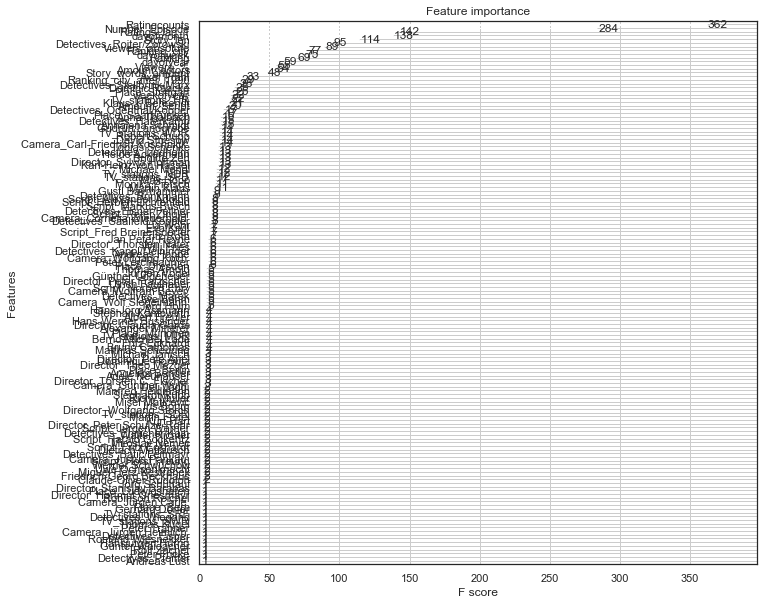

<Figure size 8640x720 with 0 Axes>

In [90]:
xgb.plot_importance(xg_class)
plt.figure(figsize=(120,10))
plt.show()

In [89]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.69902913 0.67326733 0.65346535 0.66       0.69       0.7
 0.65656566 0.68686869 0.70408163 0.69387755]
Mean: 0.6817155326588732
Standard Deviation: 0.018305607365850112


Better accuracy here, 72% which I think is good.

This is the end of the Notebook, we have: 
    
    -Scraped the data
    -Analyzed it
    -Build a recommender 
    -Forecasted the votes
    
There are still things to do, which are mentioned on the first page. 